<a href="https://colab.research.google.com/github/deadex-ng/arena/blob/main/chapter0_fundamentals/exercises/part2_cnns/0.2_CNNs_%26_ResNets_exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [0.2] - CNNs & ResNets (exercises)

> **ARENA [Streamlit Page](https://arena-chapter0-fundamentals.streamlit.app/02_[0.2]_CNNs_&_ResNets)**
>
> **Colab: [exercises](https://colab.research.google.com/github/callummcdougall/ARENA_3.0/blob/main/chapter0_fundamentals/exercises/part2_cnns/0.2_CNNs_&_ResNets_exercises.ipynb?t=20250910) | [solutions](https://colab.research.google.com/github/callummcdougall/ARENA_3.0/blob/main/chapter0_fundamentals/exercises/part2_cnns/0.2_CNNs_&_ResNets_solutions.ipynb?t=20250910)**

Please send any problems / bugs on the `#errata` channel in the [Slack group](https://join.slack.com/t/arena-uk/shared_invite/zt-3afdmdhye-Mdb3Sv~ss_V_mEaXEbkABA), and ask any questions on the dedicated channels for this chapter of material.

You can collapse each section so only the headers are visible, by clicking the arrow symbol on the left hand side of the markdown header cells.

Links to all other chapters: [(0) Fundamentals](https://arena-chapter0-fundamentals.streamlit.app/), [(1) Transformer Interpretability](https://arena-chapter1-transformer-interp.streamlit.app/), [(2) RL](https://arena-chapter2-rl.streamlit.app/).

<img src="https://raw.githubusercontent.com/info-arena/ARENA_img/main/misc/headers/header-02.png" width="350">

# Introduction

This section is designed to get you familiar with basic neural networks: how they are structured, the basic operations like linear layers and convolutions which go into making them, and why they work as well as they do. You'll start by making very simple neural networks, and by the end of today you'll build up to assembling ResNet34, a comparatively much more complicated architecture.

For a lecture on the material today, which provides some high-level understanding before you dive into the material, watch the video below:

<iframe width="540" height="304" src="https://www.youtube.com/embed/qZWrL4bBYgw" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

## Content & Learning Objectives

### 1️⃣ Making your own modules

In the first set of exercises, we'll cover the general structure of modules in PyTorch. You'll also implement your own basic modules, including for ReLU and Linear layers. You'll finish by assembling a very simple neural network.

> ##### Learning Objectives
>
> - Learn how to create your own modules in PyTorch, by inheriting from `nn.Module`
> - Assemble the pieces together to create a simple fully-connected network, to classify MNIST digits

### 2️⃣ Training Neural Networks

Here, you'll learn how to write a training loop in PyTorch. We'll keep it simple for today (and later on we'll experiment with more modular and extensible designs).

> ##### Learning Objectives
>
> - Understand how to work with transforms, datasets and dataloaders
> - Understand the basic structure of a training loop
> - Learn how to write your own validation loop

### 3️⃣ Convolutions

In this section, you'll read about convolutions, and implement them as an `nn.Module` (not from scratch; we leave that to the bonus exercises). You'll also learn about maxpooling, and implement that as well.

> ##### Learning Objectives
>
> * Learn how convolutions work, and why they are useful for vision models
> * Implement your own convolutions, and maxpooling layers

### 4️⃣ ResNets

Here, you'll combine all the pieces you've learned so far to assemble ResNet34, a much more complex architecture used for image classification.

> ##### Learning Objectives
>
> * Learn about skip connections, and how they help overcome the degradation problem
> * Learn about batch normalization, and why it is used in training
> * Assemble your own ResNet, and load in weights from PyTorch's ResNet implementation

### ☆ Bonus - Feature Extraction

In this section, you'll learn how to repurpose your ResNet to perform a different task than it was designed for, using feature extraction.

> ##### Learning Objectives
>
> * Understand the difference between feature extraction and finetuning
> * Perform feature extraction on a pre-trained ResNet

### ☆ Bonus - Convolutions From Scratch

This section takes you through the low-level details of how to actually implement convolutions. It's not necessary to understand this section to complete the exercises, but it's a good way to get a deeper understanding of how convolutions work.

> ##### Learning Objectives
>
> * Understand how array strides work, and why they're important for efficient linear operations
> * Learn how to use `as_strided` to perform simple linear operations like trace and matrix multiplication
> * Implement your own convolutions and maxpooling functions using stride-based methods

In [36]:
import os
import sys
from pathlib import Path

IN_COLAB = "google.colab" in sys.modules

chapter = "chapter0_fundamentals"
repo = "ARENA_3.0"
branch = "main"

# Install dependencies
try:
    import torchinfo
except:
    %pip install torchinfo jaxtyping

# Get root directory, handling 3 different cases: (1) Colab, (2) notebook not in ARENA repo, (3) notebook in ARENA repo
root = (
    "/content"
    if IN_COLAB
    else "/root"
    if repo not in os.getcwd()
    else str(next(p for p in Path.cwd().parents if p.name == repo))
)

if Path(root).exists() and not Path(f"{root}/{chapter}").exists():
    if not IN_COLAB:
        !sudo apt-get install unzip
        %pip install jupyter ipython --upgrade

    if not os.path.exists(f"{root}/{chapter}"):
        !wget -P {root} https://github.com/callummcdougall/ARENA_3.0/archive/refs/heads/{branch}.zip
        !unzip {root}/{branch}.zip '{repo}-{branch}/{chapter}/exercises/*' -d {root}
        !mv {root}/{repo}-{branch}/{chapter} {root}/{chapter}
        !rm {root}/{branch}.zip
        !rmdir {root}/{repo}-{branch}


if f"{root}/{chapter}/exercises" not in sys.path:
    sys.path.append(f"{root}/{chapter}/exercises")

os.chdir(f"{root}/{chapter}/exercises")

In [37]:
import nbformat

path = "/content/chapter0_fundamentals/exercises/part2_cnns/0.2_CNNs_&_ResNets_exercises.ipynb"

nb = nbformat.read(path, as_version=4)
nb.metadata.pop("widgets", None)
nbformat.write(nb, path)

print("Widget metadata removed. Close and reopen the notebook.")



Widget metadata removed. Close and reopen the notebook.


## Setup code

In [38]:
import json
import sys
from collections import namedtuple
from dataclasses import dataclass
from pathlib import Path

import einops
import numpy as np
import torch as t
import torch.nn as nn
import torch.nn.functional as F
import torchinfo
from IPython.display import display
from jaxtyping import Float, Int
from PIL import Image
from rich import print as rprint
from rich.table import Table
from torch import Tensor
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, models, transforms
from tqdm.notebook import tqdm

# Make sure exercises are in the path
chapter = "chapter0_fundamentals"
section = "part2_cnns"
root_dir = next(p for p in Path.cwd().parents if (p / chapter).exists())
exercises_dir = root_dir / chapter / "exercises"
section_dir = exercises_dir / section
if str(exercises_dir) not in sys.path:
    sys.path.append(str(exercises_dir))


import part2_cnns.tests as tests
import part2_cnns.utils as utils
from plotly_utils import line

<details>
<summary>Help - I get a NumPy-related error</summary>

This is an annoying colab-related issue which I haven't been able to find a satisfying fix for. If you restart runtime (but don't delete runtime), and run just the imports cell above again (but not the `%pip install` cell), the problem should go away.
</details>

# 1️⃣ Making your own modules

> ##### Learning Objectives
>
> - Learn how to create your own modules in PyTorch, by inheriting from `nn.Module`
> - Assemble the pieces together to create a simple fully-connected network, to classify MNIST digits

Note - from this point on we'll start referring to the PyTorch documentation pages quite a lot. We will also include a lot of content within this material if we want to highlight it for you, however it's also an important skill to be able to use documentation pages to find answers to specific questions & assist you in debugging.

## Subclassing `nn.Module`

One of the most basic parts of PyTorch that you will see over and over is the `nn.Module` class. All types of neural net components inherit from it, from the simplest `nn.Relu` to the most complex `nn.Transformer`. Often, a complex `nn.Module` will have sub-`Module`s which implement smaller pieces of its functionality.

Other common `Module`s  you'll see include

- `nn.Linear`, for fully-connected layers with or without a bias
- `nn.Conv2d`, for a two-dimensional convolution (we'll see more of these in a future section)
- `nn.Softmax`, which implements the [softmax](https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html) function

The list goes on, including activation functions, normalizations, pooling, attention, and more. You can see all the `Module`s that PyTorch provides [here](https://pytorch.org/docs/stable/nn.html). You can also create your own `Module`s, as we will do often!

The `Module` class provides a lot of functionality, but we'll only cover a little bit of it here.

In this section, we'll add another layer of abstraction to all the linear operations we've done in previous sections, by packaging them inside `nn.Module` objects.

### `__init__` and `forward`

A subclass of `nn.Module` usually looks something like this:

```python
import torch.nn as nn

class MyModule(nn.Module):
    def __init__(self, arg1, arg2, ...):
        super().__init__()
        # Initialization code

    def forward(self, x: Tensor) -> Tensor:
        # Forward pass code
```

The initialization sets up attributes that will be used for the life of the `Module`, like its parameters, hyperparameters, or other sub-`Module`s it might need to use. These are usually added to the instance with something like `self.attribute = attr`, where `attr` might be provided as an argument. Some modules are simple enough that they don't need any persistent attributes, and in this case you can skip the `__init__`.

The `forward` method is called on each forward pass of the `Module`, possibly using the attributes that were set up in the `__init__`. It should take in the input, do whatever it's supposed to do, and return the result. Subclassing `nn.Module` automatically makes instances of your class callable, so you can do `model(x)` on an input `x` to invoke the `forward` method.

### The `nn.Parameter` class

A `nn.Parameter` is a special type of `Tensor`. Basically, this is the class that torch has provided for storing the weights and biases of a `Module`. It has some special properties for doing this:

- If a `Parameter` is set as an attribute of a `Module`, it will be auto-detected by torch and returned when you call `module.parameters()` (along with all the other `Parameters` associated with the `Module`, or any of the `Module`'s sub-modules!).
- This makes it easy to pass all the parameters of a model into an optimizer and update them all at once.

When you create a `Module` that has weights or biases, be sure to wrap them in `nn.Parameter` so that torch can detect and update them appropriately:

```python
class MyModule(nn.Module):
    def __init__(self, weights: Tensor, biases: Tensor):
        super().__init__()
        self.weights = nn.Parameter(weights) # wrapping a tensor in nn.Parameter
        self.biases = nn.Parameter(biases)
```

### Printing information with `extra_repr`

Another useful method is called `extra_repr`. This allows you to format the string representation of your `Module` in a way that's more informative than the default. For example, the following:

```python
class MyModule(nn.Module):
    def __init__(self, arg1, arg2, ...):
        super().__init__()
        # Initialization code

    def extra_repr(self) -> str:
        return f"arg1={self.arg1}, arg2={self.arg2}, ..."
```

will result in the output `"MyModule(arg1=arg1, arg2=arg2, ...)"` when you print an instance of this module. You might want to take this opportunity to print out useful invariant information about the module. The Python built-in function `getattr` might be helpful here (it can be used e.g. as `getattr(self, "arg1")`, which returns the same as `self.arg1` would). For simple modules, it's fine not to implement `extra_repr`.

## ReLU

The first module you should implement is `ReLU`. This will relatively simple, since it doesn't involve any argument (so we only need to implement `forward`). Make sure you look at the PyTorch documentation page for [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html) so that you're comfortable with how they work.

ReLU is defined as the element-wise maximum between the input and a tensor of zeros. It's one of the simplest types of **nonlinear activation functions**. These are essential because linear operations compose to make more linear operations, which is very limiting. On the other hand, the **universal approximation theorem** tells us that we can approximate any continuous function using a sufficiently large neural network, if we use nonlinear activation functions. It's worth emphasizing that the theory of the UAT and what networks look like in practice are very different - in particular, many versions of the UAT are based on a shallow but extremely wide neural network, on the other hand most of the power of modern neural networks comes from their ability to compose between layers: feeding the output of one layer into the input of another, and create increasingly expressive functions. We'll explore this idea more when we study circuits in next week's interpretability material.

### Exercise - implement `ReLU`

> ```yaml
> Difficulty: 🔴🔴⚪⚪⚪
> Importance: 🔵🔵🔵⚪⚪
>
> You should spend up to ~10 minutes on this exercise.
> ```

You should fill in the `forward` method of the `ReLU` class below.

In [39]:
class ReLU(nn.Module):
    def forward(self, x: Tensor) -> Tensor:
      relu = nn.ReLU(inplace=True)
      return relu(x)



tests.test_relu(ReLU)

All tests in `test_relu` passed!


<details><summary>Solution</summary>

```python
class ReLU(nn.Module):
    def forward(self, x: Tensor) -> Tensor:
        return t.maximum(x, t.tensor(0.0))
```
</details>

## Linear

Now implement your own `Linear` module. This applies a simple linear transformation, with a weight matrix and optional bias vector. The PyTorch documentation page is [here](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html). Note that this is the first `Module` you'll implement that has learnable weights and biases.

<details>
<summary>Question - what type do you think these variables should be?</summary>

They have to be `torch.Tensor` objects wrapped in `nn.Parameter` in order for `nn.Module` to recognize them. If you forget to do this, `module.parameters()` won't include your `Parameter`, which prevents an optimizer from being able to modify it during training.
        
Also, in tomorrow's exercises we'll be building a ResNet and loading in weights from a pretrained model, and this is hard to do if you haven't registered all your parameters!
</details>

For any layer, initialization is very important for the stability of training: with a bad initialization, your model will take much longer to converge or may completely fail to learn anything. The default PyTorch behavior isn't necessarily optimal and you can often improve performance by using something more custom, but we'll follow it for today because it's simple and works decently well.

Each float in the weight and bias tensors are drawn independently from the uniform distribution on the interval:

$$
\bigg[-\frac{1}{\sqrt{N_{in}}}, \frac{1}{\sqrt{N_{in}}}\bigg]
$$

where $N_{in}$ is the number of inputs contributing to each output value. The rough intuition for this is that it keeps the variance of the activations at each layer constant, since each one is calculated by taking the sum over $N_{in}$ inputs multiplied by the weights (and standard deviation of the sum of independent random variables scales as the square root of number of variables).

This initialization technique is called **uniform Kaiming initialization**. A few last notes on initialization methods:

- Kaiming often has a different constant in the numerator depending on what the target variance is, also there are uniform & normal variants of it (we'll only be using the uniform variant)
- **Xavier initialization** is the other well-known technique, and differs in that it uses $N_{in} + N_{out}$ in the denominator (this makes sense when also considering variance scaling of backward passes as well as forward passes - see the next dropdown for technical details)

<details>
<summary>Technical details (derivation of distribution)</summary>

The key intuition behind Kaiming initialisation (and others like it) is that we want the variance of our activations to be the same through all layers of the model when we initialize. Suppose $x$ and $y$ are activations from two adjacent layers, and $w$ are the weights connecting them (so we have $y_i = \sum_j w_{ij} x_j + b_i$, where $b$ is the bias). With $N_{x}$ as the number of neurons in layer $x$, we have:

$$
\begin{aligned}
\operatorname{Var}\left(y_i\right)=\sigma_x^2 & =\operatorname{Var}\left(\sum_j w_{i j} x_j\right) \\
& =\sum_j \operatorname{Var}\left(w_{i j} x_j\right) \quad \text { Inputs and weights are independent of each other } \\
& =\sum_j \operatorname{Var}\left(w_{i j}\right) \cdot \operatorname{Var}\left(x_j\right) \quad \text { Variance of product of independent RVs with zero mean is product of variances } \\
& = N_x \cdot \sigma_x^2 \cdot \operatorname{Var}\left(w_{i j}\right) \quad \text { Variance equal for all } N_x \text { neurons, call this value } \sigma_x^2
\end{aligned}
$$

For this to be the same as $\sigma_x^2$, we need $\operatorname{Var}(w_{ij}) = \frac{1}{N_x}$, so the standard deviation is $\frac{1}{\sqrt{N_x}}$.

This is not exactly the case for the Kaiming uniform distribution (which has variance $\frac{12}{(2 \sqrt{N_x})^2} = \frac{3}{N_x}$), and as far as I'm aware there's no principled reason why PyTorch does this. But the most important thing is that the variance scales as $O(1 / N_x)$, rather than what the exact scaling constant is.

There are other initializations with some theoretical justification. For instance, **Xavier initialization** has a uniform distribution in the interval:

$$
\bigg[-\frac{\sqrt{6}}{\sqrt{N_{in} + N_{out} + 1}}, \frac{\sqrt{6}}{\sqrt{N_{in} + N_{out} + 1}}\bigg]
$$

which is motivated by the idea of both keeping the variance of activations constant and keeping the ***gradients*** constant when we backpropagate.

However, you don't need to worry about any of this here, just implement Kaiming He uniform with a bound of $\frac{1}{\sqrt{N_{in}}}$!
</details>

### Exercise - implement `Linear`

> ```yaml
> Difficulty: 🔴🔴⚪⚪⚪
> Importance: 🔵🔵🔵🔵⚪
>
> You should spend up to ~10 minutes on this exercise.
> ```

Remember, you should define the weights (and bias, if `bias=True`) in the `__init__` block. Also, make sure not to mix up `bias` (which is the boolean parameter to `__init__`) and `self.bias` (which should either be the actual bias tensor, or `None` if `bias` is false).

You should also fill in `forward` (which will multiply the input by the weight matrix and add the bias, if present).

Lastly, you should fill in `extra_repr` to give a string representation of the `Linear` module. There are no tests for this method, you should just make sure it's suitably informative (this will help when printing out your model later on).

In [40]:
class Linear(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias=True):
        """
        A simple linear (technically, affine) transformation.

        The fields should be named `weight` and `bias` for compatibility with PyTorch.
        If `bias` is False, set `self.bias` to None.
        """
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.bias = bias
        sf = 1 / np.sqrt(in_features)

        weight = sf * (2 * t.rand(out_features, in_features) - 1)
        self.weight = nn.Parameter(weight)
        if bias:
            bias = sf * (2 * t.rand(out_features) - 1)
            self.bias = nn.Parameter(bias)
        else:
            self.bias = None

    def forward(self, x: Tensor) -> Tensor:
        """
        x: shape (*, in_features)
        Return: shape (*, out_features)
        """
        y = x @ self.weight.T
        if self.bias is not None:
          y = y + self.bias
        return y
        # return x @ self.weight.T + self.bias
        # x1 = einops.einsum(x, self.weight, "... in_feats, out_feats in_feats -> ... out_feats")
        # print("x1:")
        # print(x1)
        # x = einops.einsum(x, self.weight,"ik, jk->ij")
        # print("x:")
        # print(x)
        # return x

    def extra_repr(self) -> str:
        raise NotImplementedError()


tests.test_linear_parameters(Linear, bias=False)
tests.test_linear_parameters(Linear, bias=True)
tests.test_linear_forward(Linear, bias=False)
tests.test_linear_forward(Linear, bias=True)

All tests in `test_linear_parameters` passed!
All tests in `test_linear_parameters` passed!
All tests in `test_linear_forward` passed!
All tests in `test_linear_forward` passed!


<details>
<summary>Help - when I print my Linear module, it also prints a large tensor.</summary>

This is because you've (correctly) defined `self.bias` as either `torch.Tensor` or `None`, rather than set it to the boolean value of `bias` used in initialisation.
        
To fix this, you will need to change `extra_repr` so that it prints the boolean value of `bias` rather than the value of `self.bias`.
</details>


<details><summary>Solution</summary>

```python
class Linear(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias=True):
        """
        A simple linear (technically, affine) transformation.

        The fields should be named `weight` and `bias` for compatibility with PyTorch.
        If `bias` is False, set `self.bias` to None.
        """
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.bias = bias

        sf = 1 / np.sqrt(in_features)

        weight = sf * (2 * t.rand(out_features, in_features) - 1)
        self.weight = nn.Parameter(weight)

        if bias:
            bias = sf * (2 * t.rand(out_features) - 1)
            self.bias = nn.Parameter(bias)
        else:
            self.bias = None

    def forward(self, x: Tensor) -> Tensor:
        """
        x: shape (*, in_features)
        Return: shape (*, out_features)
        """
        x = einops.einsum(x, self.weight, "... in_feats, out_feats in_feats -> ... out_feats")
        if self.bias is not None:
            x += self.bias
        return x

    def extra_repr(self) -> str:
        # note, we need to use `self.bias is not None`, because `self.bias` is either a tensor or
        # None, not bool
        return (
            f"in_features={self.in_features}, out_features={self.out_features}, "
            f"bias={self.bias is not None}"
        )
```
</details>

## Flatten

Lastly, we've given you the `Flatten` module rather than including it as an exercise (because it's simple but quite finnicky to implement). This is a standardised way to rearrange our tensors so that they can be fed into a linear layer. It's a bit like `einops.rearrange`, but more specialised and less flexible (it flattens over some contiguous range of dimensions, rather than allowing for general reshape operations). By default we use `Flatten(start_dim=1, end_dim=-1)` which means flattening over the dimensions from `input.shape[1:]`, in other words over all except the batch dimension.

Make sure you understand what this module is doing before moving on.

<!-- <details>
<summary>Help - I can't figure out what shape the output should be in Flatten.</summary>

If `input.shape = (n0, n1, ..., nk)`, and the `Flatten` module has `start_dim=i, end_dim=j`, then the new shape should be `(n0, n1, ..., ni*...*nj, ..., nk)`. This is because we're **flattening** over the dimensions `(ni, ..., nj)`.

</details>

<details>
<summary>Help - I can't see why my Flatten module is failing the tests.</summary>

The most common reason is failing to correctly handle indices. Make sure that:
* You're indexing up to **and including** `end_dim`.
* You're correctly managing the times when `end_dim` is negative (e.g. if `input` is an nD tensor, and `end_dim=-1`, this should be interpreted as `end_dim=n-1`).
</details> -->

In [41]:
class Flatten(nn.Module):
    def __init__(self, start_dim: int = 1, end_dim: int = -1) -> None:
        super().__init__()
        self.start_dim = start_dim
        self.end_dim = end_dim

    def forward(self, input: Tensor) -> Tensor:
        """
        Flatten out dimensions from start_dim to end_dim, inclusive of both.
        """
        shape = input.shape

        # Get start & end dims, handling negative indexing for end dim
        start_dim = self.start_dim
        end_dim = self.end_dim if self.end_dim >= 0 else len(shape) + self.end_dim

        # Get the shapes to the left / right of flattened dims, as well as size of flattened middle
        shape_left = shape[:start_dim]
        shape_right = shape[end_dim + 1 :]
        shape_middle = t.prod(t.tensor(shape[start_dim : end_dim + 1])).item()

        return t.reshape(input, shape_left + (shape_middle,) + shape_right)

    def extra_repr(self) -> str:
        return ", ".join([f"{key}={getattr(self, key)}" for key in ["start_dim", "end_dim"]])

## Simple Multi-Layer Perceptron

Now, we can put together these two modules to create a neural network. We'll create one of the simplest networks which can be used to separate data that is non-linearly separable: a single linear layer, followed by a nonlinear function (ReLU), followed by another linear layer. This type of architecture (alternating linear layers and nonlinear functions) is often called a **multi-layer perceptron** (MLP).

The output of this network will have 10 dimensions, corresponding to the 10 classes of MNIST digits. We can then use the **softmax function** $x_i \to \frac{e^{x_i}}{\sum_i e^{x_i}}$ to turn these values into probabilities. However, it's common practice for the output of a neural network to be the values before we take softmax, rather than after. We call these pre-softmax values the **logits**.

<details>
<summary>Question - can you see what makes logits non-unique (i.e. why any given set of probabilities might correspond to several different possible sets of logits)?</summary>

Logits are **translation invariant**. If you add some constant $c$ to all logits $x_i$, then the new probabilities are:

$$
p_i' = \frac{e^{x_i + c}}{\sum_j e^{x_j + c}} = \frac{e^{x_i}}{\sum_j e^{x_j}} = p_i
$$

in other words, the probabilities don't change.

We can define **logprobs** as the log of the probabilities, i.e. $y_i = \log p_i$. Unlike logits, these are uniquely defined.

</details>

### Exercise - implement the simple MLP

> ```yaml
> Difficulty: 🔴🔴🔴⚪⚪
> Importance: 🔵🔵🔵🔵⚪
>
> You should spend up to ~20 minutes on this exercise.
> ```

The diagram below shows what your MLP should look like:

<img src="https://raw.githubusercontent.com/info-arena/ARENA_img/main/misc/mlp-mermaid.svg" width="170">

Please ask a TA (or message the Slack group) if any part of this diagram is unclear.

In [42]:
class SimpleMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = Flatten()
        self.linear1 = Linear(in_features=28 * 28, out_features=100)
        self.relu = ReLU()
        self.linear2 = Linear(in_features=100, out_features=10)

    def forward(self, x: Tensor) -> Tensor:
        return self.linear2(self.relu(self.linear1(self.flatten(x))))


tests.test_mlp_module(SimpleMLP)
tests.test_mlp_forward(SimpleMLP)

All tests in `test_mlp_module` passed!
All tests in `test_mlp_forward` passed!


<details><summary>Solution</summary>

```python
class SimpleMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = Flatten()
        self.linear1 = Linear(in_features=28 * 28, out_features=100)
        self.relu = ReLU()
        self.linear2 = Linear(in_features=100, out_features=10)

    def forward(self, x: Tensor) -> Tensor:
        return self.linear2(self.relu(self.linear1(self.flatten(x))))
```
</details>

In the next section, we'll learn how to train and evaluate our model on real data.

# 2️⃣ Training Neural Networks

> ##### Learning Objectives
>
> - Understand how to work with transforms, datasets and dataloaders
> - Understand the basic structure of a training loop
> - Learn how to write your own validation loop

## Transforms, Datasets & DataLoaders

Before we use this model to make any predictions, we first need to think about our input data. Below is a block of code to fetch and process MNIST data. We will go through it line by line.

In [43]:
MNIST_TRANSFORM = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(0.1307, 0.3081),
    ]
)


def get_mnist(trainset_size: int = 10_000, testset_size: int = 1_000) -> tuple[Subset, Subset]:
    """Returns a subset of MNIST training data."""

    # Get original datasets, which are downloaded to "./data" for future use
    mnist_trainset = datasets.MNIST(
        exercises_dir / "data", train=True, download=True, transform=MNIST_TRANSFORM
    )
    mnist_testset = datasets.MNIST(
        exercises_dir / "data", train=False, download=True, transform=MNIST_TRANSFORM
    )

    # # Return a subset of the original datasets
    mnist_trainset = Subset(mnist_trainset, indices=range(trainset_size))
    mnist_testset = Subset(mnist_testset, indices=range(testset_size))

    return mnist_trainset, mnist_testset


mnist_trainset, mnist_testset = get_mnist()
mnist_trainloader = DataLoader(mnist_trainset, batch_size=64, shuffle=True)
mnist_testloader = DataLoader(mnist_testset, batch_size=64, shuffle=False)

# Get the first batch of test data, by starting to iterate over `mnist_testloader`
for img_batch, label_batch in mnist_testloader:
    print(f"{img_batch.shape=}\n{label_batch.shape=}\n")
    break

# Get the first datapoint in the test set, by starting to iterate over `mnist_testset`
for img, label in mnist_testset:
    print(f"{img.shape=}\n{label=}\n")
    break

t.testing.assert_close(img, img_batch[0])
assert label == label_batch[0].item()

img_batch.shape=torch.Size([64, 1, 28, 28])
label_batch.shape=torch.Size([64])

img.shape=torch.Size([1, 28, 28])
label=7



In [44]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt


training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

imge 4
imge 7
imge 1
imge 5
imge 0
imge 6
imge 4
imge 1
imge 7


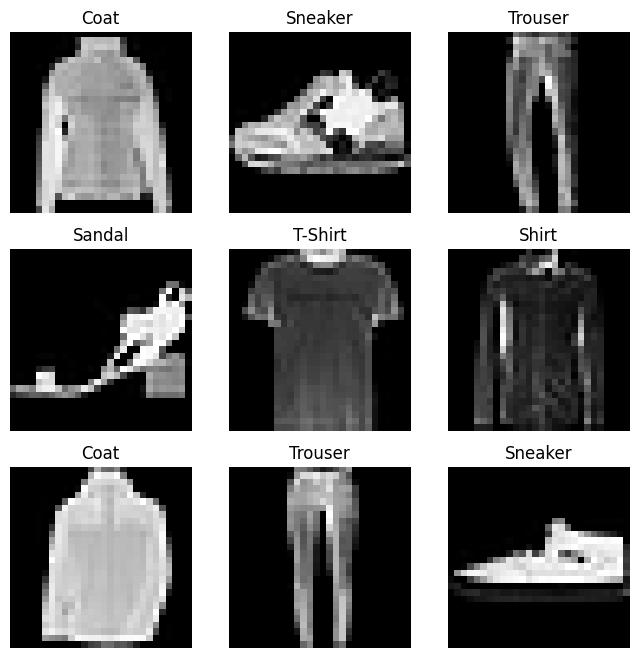

In [45]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    print("imge", label)
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [46]:
from torchvision import datasets, transforms

dataset_raw = datasets.MNIST(
    "data", train=True, download=True, transform=None
)

dataset_tensor = datasets.MNIST(
    "data", train=True, download=True, transform=transforms.ToTensor()
)

raw_img, _ = dataset_raw[0]
tensor_img, _ = dataset_tensor[0]

print("Raw pixel max:", raw_img.getextrema())
print("Tensor min/max:", tensor_img.min().item(), tensor_img.max().item())


Raw pixel max: (0, 255)
Tensor min/max: 0.0 1.0


The `torchvision` package consists of popular datasets, model architectures, and common image transformations for computer vision, and `torchvision.transforms` provides access to a suite of functions for preprocessing data. We define a transform for the MNIST data (which is applied to each image in the dataset) by composing `ToTensor` (which converts a `PIL.Image` object into a PyTorch tensor) and `Normalize` (which takes arguments for the mean and standard deviation, and performs the linear transformation `x -> (x - mean) / std`). For the latter, we use `0.1307` and `0.3081` which are the empirical mean & std of the raw data (so after this transformation, the data will have mean 0 and variance 1).

Next, we define our datasets using `torchvision.datasets`. The first argument tells us where to save our data to (so that when we run this in the future we won't have to re-save it), and `transform=MNIST_TRANSFORM` tells us that we should apply our previously defined `transform` to each element in our dataset. We also use `Subset` which allows us to return a slice of the dataset rather than the whole thing (because our model won't need much data to train!).

Finally, since our dataset only allows for iteration over individual datapoints, we wrap it in `DataLoader` which enables iteration over **batches**. It also provides useful arguments like `shuffle`, which determine whether we randomize the order after each epoch. The code above demonstrates iteration over the dataset & dataloader respectively, showing how the first element in the dataloader's first batch equals the first element in the dataset (note that this wouldn't be true for the training set, because we've shuffled it).

<details>
<summary>Aside - why batch sizes are often powers of 2</summary>

It's common to see batch sizes which are powers of two. The motivation is for efficient GPU utilisation, since processor architectures are normally organised around powers of 2, and computational efficiency is often increased by having the items in each batch split across processors. Or at least, that's the idea. The truth is a bit more complicated, and some studies dispute whether it actually saves time, so at this point it's more of a standard convention than a hard rule which will always lead to more efficient training.

</details>

Before proceeding, try and answer the following questions:


<details>
<summary>Question - can you explain why we include a data normalization function in <code>torchvision.transforms</code> ?</summary>

One consequence of unnormalized data is that you might find yourself stuck in a very flat region of the domain, and gradient descent may take much longer to converge.

Normalization isn't strictly necessary for this reason, because any rescaling of an input vector can be effectively undone by the network learning different weights and biases. But in practice, it does usually help speed up convergence.

Normalization also helps avoid numerical issues.
</details>

<details>
<summary>Question - what is the benefit of using <code>shuffle=True</code> when defining our dataloaders? What might the problem be if we didn't do this?</summary>

Shuffling is done during the training to make sure we aren't exposing our model to the same cycle (order) of data in every epoch. It is basically done to ensure the model isn't adapting its learning to any kind of spurious pattern.
</details>

### Aside - `tqdm`

You might have seen some blue progress bars running when you first downloaded your MNIST data. These were generated using a library called `tqdm`, which is also a really useful tool when training models or running any process that takes a long period of time.

The `tqdm` function wraps around an iterable, and displays a progress bar as you iterate through it. The code below shows a minimal example:

```python
from tqdm.notebook import tqdm
import time

for i in tqdm(range(100)):
    time.sleep(0.1)
```

There are some more advanced features of `tqdm` too, for example:

- If you define the progress bar `pbar = tqdm(...)` before your iteration, then you have the option of adding extra information to it using `pbar.set_description` or `pbar.set_postfix`
- You can specify the total number of iterations with `tqdm(iterable, total=...)`; this is actually very important when the iterable is something like `enumerate(...)` which doesn't have a length attribute, since tqdm will usually try and infer the total from calling `len` on the iterable you pass it.

Here's some code that demonstrates these extra features:

```python
word = "hello!"
pbar = tqdm(enumerate(word), total=len(word))
t0 = time.time()

for i, letter in pbar:
    time.sleep(1.0)
    pbar.set_postfix(i=i, letter=letter, time=f"{time.time()-t0:.3f}")
```

In [47]:
import torch
device = torch.device(
    "mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu"
)

print(torch.cuda.is_available())
X_train = torch.FloatTensor([0., 1., 2.])
print(X_train.is_cuda)
X_train = X_train.to(device)
print(X_train.is_cuda)

False
False
False


### Aside - `device`

One last thing to discuss before we move onto training our model: **GPUs**. We'll discuss this in more detail in later exercises. For now, [this page](https://wandb.ai/wandb/common-ml-errors/reports/How-To-Use-GPU-with-PyTorch---VmlldzozMzAxMDk) should provide a basic overview of how to use your GPU. A few things to be aware of here:

* The `to` method is really useful here - it can move objects between different devices (i.e. CPU and GPU) *as well as* changing a tensor's datatype.
    * Note that `to` is never inplace for tensors (i.e. you have to call `x = x.to(device)`), but when working with models, calling `model = model.to(device)` or `model.to(device)` are both perfectly valid.
* Errors from having one tensor on cpu and another on cuda are very common. Some useful practices to avoid this:
    * Throw in assert statements, to make sure tensors are on the same device
    * Remember that when you initialise an array (e.g. with `t.zeros` or `t.arange`), it will be on CPU by default.
    * Tensor methods like [`new_zeros`](https://pytorch.org/docs/stable/generated/torch.Tensor.new_zeros.html) or [`new_full`](https://pytorch.org/docs/stable/generated/torch.Tensor.new_full.html) are useful, because they'll create tensors which match the device and dtype of the base tensor.

It's common practice to put a line like this at the top of your file, defining a global variable which you can use in subsequent modules and functions (excluding the print statement):

In [48]:
device = t.device(
    "mps" if t.backends.mps.is_available() else "cuda" if t.cuda.is_available() else "cpu"
)

# If this is CPU, we recommend figuring out how to get cuda access (or MPS if you're on a Mac).
print(device)

cpu


## Training loop

Below is a very simple training loop, which you can run to train your model.

In later exercises, we'll try to **modularize** our training loops. This will involve things like creating a `Trainer` class which wraps around our model, and giving it methods like `training_step` and `validation_step` which correspond to different parts of the training loop. This will make it easier to add features like logging and validation, and will also make our code more readable and easier to refactor. However, for now we've kept things simple.

In [49]:
model = SimpleMLP().to(device)

batch_size = 128
epochs = 3

mnist_trainset, _ = get_mnist()
mnist_trainloader = DataLoader(mnist_trainset, batch_size=batch_size, shuffle=True)

optimizer = t.optim.Adam(model.parameters(), lr=1e-3)
loss_list = []

for epoch in range(epochs):
    pbar = tqdm(mnist_trainloader)

    for imgs, labels in pbar:
        # Move data to device, perform forward pass
        imgs, labels = imgs.to(device), labels.to(device)
        logits = model(imgs)

        # Calculate loss, perform backward pass
        loss = F.cross_entropy(logits, labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # Update logs & progress bar
        loss_list.append(loss.item())
        pbar.set_postfix(epoch=f"{epoch + 1}/{epochs}", loss=f"{loss:.3f}")

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

In [50]:
line(
    loss_list,
    x_max=epochs * len(mnist_trainset),
    labels={"x": "Examples seen", "y": "Cross entropy loss"},
    title="SimpleMLP training on MNIST",
    width=700,
)

Let's break down the important parts of this code.

The batch size is the number of samples in each batch (i.e. the number of samples we feed into the model at once). While training our model, we differentiate with respect to the average loss over all samples in the batch (so a smaller batch usually means the loss is more noisy). However, if you're working with large models, then often having a batch size too large will result in a memory error. This will be relevant for models later on in the course, but for now we're working with very small models so this isn't an issue.

Next, we get our training set, via the helper function `get_mnist`. This helper function used `torchvision.datasets.MNIST` to load in data, and then (optionally) the `torch.utils.data.Subset` function to return a subset of this data. Don't worry about the details of this function, it's not the kind of thing you'll need to know by heart.

We then define our optimizer, using `torch.optim.Adam`. The `torch.optim` module gives a wide variety of modules, such as Adam, SGD, and RMSProp. Adam is generally the most popular and seen as the most effective in the majority of cases. We'll discuss optimizers in more detail tomorrow, but for now it's enough to understand that the optimizer calculates the amount to update parameters by (as a function of those parameters' gradients, and sometimes other inputs), and performs this update step. The first argument passed to our optimizer is the parameters of our model (because these are the values that will be updated via gradient descent), and you can also pass keyword arguments to the optimizer which change its behaviour (e.g. the learning rate).

Lastly, we have the actual training loop. We iterate through our training data, and for each batch we:

1. Evaluate our model on the batch of data, to get the logits for our class predictions,
2. Calculate the loss between our logits and the true class labels,
3. Backpropagate the loss through our model (this step accumulates gradients in our model parameters),
4. Step our optimizer, which is what actually updates the model parameters,
5. Zero the gradients of our optimizer, ready for the next step.

### Cross entropy loss

The formula for cross entropy loss over a batch of size $N$ is:

$$
\begin{aligned}
l &= \frac{1}{N} \sum_{n=1}^{N} l_n \\
l_n &=-\log p_{n, y_{n}}
\end{aligned}
$$

where $p_{n, c}$ is the probability the model assigns to class $c$ for sample $n$, and $y_{n}$ is the true label for this sample.

<details>
<summary>See this dropdown, if you're still confused about this formula, and how this relates to the information-theoretic general formula for cross entropy.</summary>

The cross entropy of a distribution $p$ relate to a distribution $q$ is:

$$
\begin{aligned}
H(q, p) &= -\sum_{n} q(n) \log p(n)
\end{aligned}
$$

In our case, $q$ is the true distribution (i.e. the one-hot encoded labels, which equals one for $n = y_n$, zero otherwise), and $p$ is our model's output. With these subsitutions, this formula becomes equivalent to the formula for $l$ given above.
</details>

<details>
<summary>See this dropdown, if you're confused about how this is the same as the <a href="https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss">PyTorch definition</a>.</summary>

The PyTorch definition of cross entropy loss is:

$$
\ell(x, y)=\frac{1}{N}\sum_{n=1}^{N} l_n, \quad l_n=-\sum_{c=1}^C w_c \log \frac{\exp \left(x_{n, c}\right)}{\sum_{i=1}^C \exp \left(x_{n, i}\right)} y_{n, c}
$$

$w_c$ are the weights (which all equal one by default), $p_{n, c} = \frac{\exp \left(x_{n, c}\right)}{\sum_{i=1}^C \exp \left(x_{n, i}\right)}$ are the probabilities, and $y_{n, c}$ are the true labels (which are one-hot encoded, i.e. their value is one at the correct label $c$ and zero everywhere else). With this, the formula for $l_n$ reduces to the one we see above (i.e. the mean of the negative log probabilities).

</details>

The function `torch.functional.cross_entropy` expects the **unnormalized logits** as its first input, rather than probabilities. We get probabilities from logits by applying the softmax function:

$$
\begin{aligned}
p_{n, c} &= \frac{\exp(x_{n, c})}{\sum_{c'=1}^{C} \exp(x_{n, c'})}
\end{aligned}
$$

where $x_{n, c}$ is the model's output for class $c$ and sample $n$, and $C$ is the number of classes (in the case of MNIST, $C = 10$).

Some terminology notes:

* When we say **logits**, we mean the output of the model before applying softmax. We can uniquely define a distribution with a set of logits, just like we can define a distribution with a set of probabilities (and sometimes it's easier to think of a distribution in terms of logits, as we'll see later in the course).

* When we say **unnormalized**, we mean the denominator term $\sum_{c'} \exp(x_{n, c'})$ isn't necessarily equal to 1. We can add a constant value onto all the logits which makes this term 1 without changing any of the actual probabilities, then we have the relation $p_{n, c} = \exp(-l_{n, c})$. Here, we call $-l_{n, c}$ the **log probabilities** (or log probs), since $-l_{n, c} = \log p_{n, c}$.

If you're interested in the intuition behind cross entropy as a loss function, see [this post on KL divergence](https://www.lesswrong.com/posts/no5jDTut5Byjqb4j5/six-and-a-half-intuitions-for-kl-divergence) (note that KL divergence and cross entropy differ by an amount which is independent of our model's predictions, so minimizing cross entropy is equivalent to minimizing KL divergence). Also see these two videos:

* [Intuitively Understanding the Cross Entropy Loss](https://www.youtube.com/watch?v=Pwgpl9mKars&amp;ab_channel=AdianLiusie)
* [Intuitively Understanding the KL Divergence](https://www.youtube.com/watch?v=SxGYPqCgJWM&amp;ab_channel=AdianLiusie)

### Aside - `dataclasses`

Sometimes, when we have a lot of different input parameters to our model, it can be helpful to use dataclasses to keep track of them all. Dataclasses are a special kind of class which come with built-in methods for initialising and printing (i.e. no need to define an `__init__` or `__repr__`). Another advantage of using them is autocompletion: when you type in `args.` in VSCode, you'll get a dropdown of all your different dataclass attributes, which can be useful when you've forgotten what you called a variable!

Here's an example of how we might rewrite our training code above using dataclasses. We've wrapped all the training code inside a single argument called `train`, which takes a `SimpleMLPTrainingArgs` object as its only argument.

In [51]:
@dataclass
class SimpleMLPTrainingArgs:
    """
    Defining this class implicitly creates an __init__ method, which sets arguments as below, e.g.
    self.batch_size=64. Any of these fields can also be overridden when you create an instance, e.g.
    SimpleMLPTrainingArgs(batch_size=128).
    """

    batch_size: int = 64
    epochs: int = 3
    learning_rate: float = 1e-3


def train(args: SimpleMLPTrainingArgs) -> tuple[list[float], SimpleMLP]:
    """
    Trains & returns the model, using training parameters from the `args` object. Returns the model,
    and loss list.
    """
    model = SimpleMLP().to(device)

    mnist_trainset, _ = get_mnist()
    mnist_trainloader = DataLoader(mnist_trainset, batch_size=args.batch_size, shuffle=True)

    optimizer = t.optim.Adam(model.parameters(), lr=args.learning_rate)
    loss_list = []

    for epoch in range(args.epochs):
        pbar = tqdm(mnist_trainloader)

        for imgs, labels in pbar:
            # Move data to device, perform forward pass
            imgs, labels = imgs.to(device), labels.to(device)
            logits = model(imgs)

            # Calculate loss, perform backward pass
            loss = F.cross_entropy(logits, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            # Update logs & progress bar
            loss_list.append(loss.item())
            pbar.set_postfix(epoch=f"{epoch + 1}/{args.epochs}", loss=f"{loss:.3f}")

    return loss_list, model


args = SimpleMLPTrainingArgs()
loss_list, model = train(args)

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

In [52]:
line(
    loss_list,
    x_max=args.epochs * len(mnist_trainset),
    labels={"x": "Examples seen", "y": "Cross entropy loss"},
    title="SimpleMLP training on MNIST",
    width=700,
)

### Exercise - add a validation loop

> ```yaml
> Difficulty: 🔴🔴🔴⚪⚪
> Importance: 🔵🔵🔵🔵🔵
>
> You should spend up to ~20 minutes on this exercise.
> It is very important that you understand training loops and how they work, because we'll be doing a lot of model training in this way.
> ```

Edit the `train` function above to include a validation loop. Train your model, making sure you measure the accuracy at the end of each epoch.

Here are a few tips to help you:

* You'll need a dataloader for the testset, just like we did for the trainset. It doesn't matter whether you shuffle the testset or not, because we're not updating our model parameters during validation (we usually set `shuffle=False` for testsets).
    * You can set the same batch size as for your training set (we'll discuss more optimal choices for this later in the course).
* During the validation step, you should be measuring **accuracy**, which is defined as **the fraction of correctly classified images**.
    * Note that (unlike loss) accuracy should only be logged after you've gone through the whole validation set. This is because your model doesn't update between computing different accuracies, so it doesn't make sense to log all of them separately.
    * Computing accuracy is meant to be a very short operation, so you shouldn't need a progress bar.
    * You can wrap your forward pass in `with t.inference_mode():` to make sure that your model is in inference mode during validation (i.e. gradients don't propagate).

In [53]:
def train(args: SimpleMLPTrainingArgs) -> tuple[list[float], list[float], SimpleMLP]:
    """
    Trains the model, using training parameters from the `args` object.

    Returns:
        The model, and lists of loss & accuracy.
    """
    model = SimpleMLP().to(device)
    mnist_trainset, mnist_testset = get_mnist()
    mnist_trainloader = DataLoader(mnist_trainset, batch_size=args.batch_size, shuffle=True)
    mnist_testloader = DataLoader(mnist_testset, batch_size=args.batch_size, shuffle=False)
    optimizer = t.optim.Adam(model.parameters(), lr=args.learning_rate)

    loss_list = []
    accuracy_list = []
    accuracy = 0.0

    for epoch in range(args.epochs):
        # Training loop
        pbar = tqdm(mnist_trainloader)
        for imgs, labels in pbar:
          imgs, labels = imgs.to(device), labels.to(device)
          logits = model(imgs)

          loss = F.cross_entropy(logits, labels)
          loss.backward()
          optimizer.step()
          optimizer.zero_grad()

          loss_list.append(loss.item())
          pbar.set_postfix(epoch=f"{epoch + 1}/{args.epochs}", loss=f"{loss:.3f}")

        num_correct_classifications = 0
        for imgs, labels in mnist_testloader:
          imgs, labels = imgs.to(device), labels.to(device)
          with t.inference_mode():
            logits = model(imgs)

          predictions = t.argmax(logits, dim=1)
          num_correct_classifications += (predictions == labels).sum().item()
        accuracy = num_correct_classifications / len(mnist_testset)
        accuracy_list.append(accuracy)

    return loss_list, accuracy_list, model


args = SimpleMLPTrainingArgs()
loss_list, accuracy_list, model = train(args)

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

In [54]:
line(
    y=[loss_list, [0.1] + accuracy_list],  # we start by assuming a uniform accuracy of 10%
    use_secondary_yaxis=True,
    x_max=args.epochs * len(mnist_trainset),
    labels={"x": "Num examples seen", "y1": "Cross entropy loss", "y2": "Test Accuracy"},
    title="SimpleMLP training on MNIST",
    width=800,
)

<details>
<summary>Help - I'm not sure how to measure correct classifications.</summary>

You can take argmax of the output of your model, using `torch.argmax` (with the keyword argument `dim` to specify the dimension you want to take max over).

</details>

<details>
<summary>Help - I get <code>RuntimeError: expected scalar type Float but found Byte</code>.</summary>

This is commonly because one of your operations is between tensors with the wrong datatypes (e.g. `int` and `float`). You can try adding assert or logging statements in your code, or alternatively if you're in VSCode then you can try navigating to the error line and checking your dtypes using VSCode's built-in debugger.
</details>


<details><summary>Solution</summary>

```python
def train(args: SimpleMLPTrainingArgs) -> tuple[list[float], list[float], SimpleMLP]:
    """
    Trains the model, using training parameters from the `args` object.

    Returns:
        The model, and lists of loss & accuracy.
    """
    model = SimpleMLP().to(device)

    mnist_trainset, mnist_testset = get_mnist()
    mnist_trainloader = DataLoader(mnist_trainset, batch_size=args.batch_size, shuffle=True)
    mnist_testloader = DataLoader(mnist_testset, batch_size=args.batch_size, shuffle=False)

    optimizer = t.optim.Adam(model.parameters(), lr=args.learning_rate)

    loss_list = []
    accuracy_list = []
    accuracy = 0.0

    for epoch in range(args.epochs):
        # Training loop
        pbar = tqdm(mnist_trainloader)
        for imgs, labels in pbar:
            # Move data to device, perform forward pass
            imgs, labels = imgs.to(device), labels.to(device)
            logits = model(imgs)

            # Calculate loss, perform backward pass
            loss = F.cross_entropy(logits, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            # Update logs & progress bar
            loss_list.append(loss.item())
            pbar.set_postfix(epoch=f"{epoch + 1}/{args.epochs}", loss=f"{loss:.3f}")

        # Validation loop
        num_correct_classifications = 0
        for imgs, labels in mnist_testloader:
            # Move data to device, perform forward pass in inference mode
            imgs, labels = imgs.to(device), labels.to(device)
            with t.inference_mode():
                logits = model(imgs)

            # Compute num correct by comparing argmaxed logits to true labels
            predictions = t.argmax(logits, dim=1)
            num_correct_classifications += (predictions == labels).sum().item()

        # Compute & log total accuracy
        accuracy = num_correct_classifications / len(mnist_testset)
        accuracy_list.append(accuracy)

    return loss_list, accuracy_list, model
```
</details>

You should find that after the first epoch, the model is already doing much better than random chance (i.e. >80%), and it improves slightly in subsequent epochs.

# 3️⃣ Convolutions

> ##### Learning Objectives
>
> * Learn how convolutions work, and why they are useful for vision models
> * Implement your own convolutions, and maxpooling layers

_Note, this section is light on exercises, because it actually ends up being surprisingly hard to implement convolutional and linear operations from scratch (unlike the case for linear layers). It requires engaging with **strides**, an under-the-hood attribute of PyTorch tensors which we usually don't think about in regular work. For this reason, this section focuses more on understanding how convolutions work & giving you implementations of it, rather than asking you to implement it from scratch. There are implementation from scratch exercises in the bonus section at the end of today's material, if you get that far!_

## Reading

We strongly recommend you at least watch the video in the first bullet point. The second article is recommended, but not essential. The third is more for interest (and will be more relevant next week, when we study interpretability).

* [But what is a convolution?](https://www.youtube.com/watch?v=KuXjwB4LzSA) by 3Blue1Brown
* [A Comprehensive Guide to Convolutional Neural Networks (Medium)](https://medium.com/towards-data-science/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53)
* [Zoom In: An Introduction to Circuits](https://distill.pub/2020/circuits/zoom-in/)

## What are convolutions?

A convolution is an operation which takes a kernel and slides it across the input, applying the kernel to each patch of the input. We can view it as a logical extension of the linear layer, except rather than having every output value being determined as a linear combination of every input value, we have a **prior of locality** - assuming that the input has some spatial structure, and each output value should only be determined by a small patch of the input. The kernel contains our learned weights, and we slide that kernel across our input, with each output value being computed by a sumproduct of the kernel values and the corresponding patch in the input. Note that we use all input channels when computing each output value, which means the sumproduct is over `kernel_length * in_channels` elements (or `kernel_width * kernel_height * in_channels` when, as is most often the case, we're using 2D kernels).

### Mathematical definition

Convolutions have 4 important parameters:

- **Size** - the size of the kernel, i.e. the size of each patch of the input that the kernel is applied to when computing each output value.
- **Stride** - the distance the kernel moves each time it is applied.
- **Padding** - the number of pixels we pad around the input on each side.
- **Output channels** - the number of separate kernels of shape `(in_channels, kernel_width, kernel_height)` we apply to the input. Each separate kernel has different learned weights, and will produce a separate output channel.

Below is an illustration with `size=(3,3), stride=1, padding=1`, three input channels and a single output channel. Note that although the illustration below only shows padding on the left and top of the image, in reality we pad all sides of the image.

<img src="https://miro.medium.com/v2/resize:fit:1400/1*ciDgQEjViWLnCbmX-EeSrA.gif" width="800">

For width or height, we can compute the output dim size as a function of the input dim and convolution parameters:

$$
L_{\text {out }}=\left\lfloor\dfrac{L_{\text {in }}+2 \times \text { padding }- \text { kernel\_size }}{\text { stride }}+1\right\rfloor
$$

Notably, with our parameters `size=(3,3), stride=1, padding=1` this simplifies to $L_{\text{out}} = \left\lfloor\frac{L_{\text{in}} + 2 - 3}{1} + 1\right\rfloor = L_{\text{in}}$. We refer to this as a **shape-preserving convolution**, because the input & output dimensions for width/height are the same. This is quite useful because often when building neural networks we have to be careful to match the shapes of different tensors (otherwise skip connections will fail - we can't add together `x + conv(x)` if they're different shapes!).

> A quick note on terminology - you might see docs and docstrings use `num_features`, sometimes use `channels` (sometimes abbreviated as $N_{in}$ or $C$ in PyTorch docs). When we're talking about convolutions specifically, these usually mean the same thing.

### What do convolutions learn?

The terminology `num_features` hints at this, but often convolutions can be thought of as learning certain features from our data. For instance, there's evidence to suggest that early convolutional layers pick up on very simple low-level features such as edges, corners and curves, whereas later convolutional layers are able to combine these lower-level features hierarchically to form more complex representations.

For more on this, we recommend the Distill post [Zoom In: An Introduction to Circuits](https://distill.pub/2020/circuits/zoom-in/), which discusses various lines of evidence for interpreting the features learned by convolutional layers (and how they connect up to form circuits). Interestingly, this post philosophically underpins quite a lot of the current interpretability field - even though the focus has primarily shifted from vision models to language models, many of the underlying ideas remain the same.

<img src="https://distill.pub/2020/circuits/zoom-in/images/curves.png" width="700">

### Some questions about convolutions

Here are some questions about convolutions to make sure you've understood the material. You should try and answer these questions without referring back to the article or video above.

<details>
<summary>Why would convolutional layers be less likely to overfit data than standard linear (fully connected) layers?</summary>

Convolutional layers require significantly fewer weights to be learned. This is because the same kernel is applied all across the image, rather than every pair of `(input, output)` nodes requiring a different weight to be learned.
</details>

<details>
<summary>Suppose you fixed some random permutation of the pixels in an image, and applied this to all images in your dataset, before training a convolutional neural network for classifying images. Do you expect this to be less effective, or equally effective?</summary>

It will be less effective, because CNNs work thanks to **spatial locality** - groups of pixels close together are more meaningful. For instance, CNNs will often learn convolutions at an early layer which recognise gradients or simple shapes. If you permute the pixels (even if you permute in the same way for every image), you destroy locality.
</details>

<details>
<summary>If you have a 28x28 image, and you apply a 3x3 convolution with stride 2, padding 1, and 5 output channels, what shape will the output be?</summary>

Applying the formula above, we get:

$
L_{\text {out }}=\left\lfloor\frac{L_{\text {in }}+2 \times \text { padding }- \text { kernel\_size }}{\text { stride }}+1\right\rfloor = \left\lfloor\frac{28 + 2 \times 1 - 3}{2} + 1\right\rfloor = 14
$

So our image has width & height 14. The shape will go from `(3, 28, 28)` to `(5, 14, 14)` (since the output dimensions are `out_channels, width, height`).

As a general rule, a 3x3 convolution with padding 1, stride `stride` and input images with shape `(width, height)` will map to an output shape of `(width // stride, height // stride)`. This will be useful when we study GANs tomorrow, and we'll assemble a series of 3x3 convolutions with padding 1 and stride 2, which should each halve our input image size.

</details>

### Exercise - implement `Conv2d`

> ```yaml
> Difficulty: 🔴🔴⚪⚪⚪
> Importance: 🔵🔵🔵⚪⚪
>
> You should spend up to 10-20 minutes on this exercise.
> This only requires you to create the conv weights - making your own fwd pass method is a bonus exercise later.
> ```

Rather than implementing the `conv2d` function from scratch, we'll allow you to use `t.nn.functional.conv2d`. In the exercise below, you should use this function to implement the `nn.Conv2d` layer. All you need to do is fill in the `__init__` method. Some guidance:

- You should look at the PyTorch page for `nn.Conv2d` [here](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) (and review the discussion above) to understand what the shape of the weights should be.
- We assume `bias=False`, so the only `nn.Parameter` object we need to define is `weight`.
- You should use **uniform Kaiming initialization** like you have before, i.e. the bounds of the uniform distribution should be $\pm 1/\sqrt{N_{in}}$ where $N_{in}$ is the product of input channels and kernel height & width, as described at the bottom of the `nn.Conv2d` docs (the bullet points under the **Variables** header).

<details>
<summary>Question - why do you think we use the product of input channels and kernel height & width for our Kaiming initialization bounds?</summary>

This is because each value in the output is computed by taking the product over `in_channels * kernel_height * kernel_width` elements, analogously to how each value in the linear layer is computed by taking the product over just `in_features` elements.

</details>

In [55]:
class Conv2d(nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        kernel_size: int,
        stride: int = 1,
        padding: int = 0,
    ):
        """
        Same as torch.nn.Conv2d with bias=False.

        Name your weight field `self.weight` for compatibility with the PyTorch version.

        We assume kernel is square, with height = width = `kernel_size`.
        """
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding

        # YOUR CODE HERE - define & initialize `self.weight`
        raise NotImplementedError()

    def forward(self, x: Tensor) -> Tensor:
        """Apply the functional conv2d, which you can import."""
        return t.nn.functional.conv2d(x, self.weight, stride=self.stride, padding=self.padding)

    def extra_repr(self) -> str:
        keys = ["in_channels", "out_channels", "kernel_size", "stride", "padding"]
        return ", ".join([f"{key}={getattr(self, key)}" for key in keys])


tests.test_conv2d_module(Conv2d)
m = Conv2d(in_channels=24, out_channels=12, kernel_size=3, stride=2, padding=1)
print(f"Manually verify that this is an informative repr: {m}")

NotImplementedError: 

<details><summary>Solution</summary>

```python
class Conv2d(nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        kernel_size: int,
        stride: int = 1,
        padding: int = 0,
    ):
        """
        Same as torch.nn.Conv2d with bias=False.

        Name your weight field `self.weight` for compatibility with the PyTorch version.

        We assume kernel is square, with height = width = `kernel_size`.
        """
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding

        kernel_height = kernel_width = kernel_size
        sf = 1 / np.sqrt(in_channels * kernel_width * kernel_height)
        self.weight = nn.Parameter(
            sf * (2 * t.rand(out_channels, in_channels, kernel_height, kernel_width) - 1)
        )

    def forward(self, x: Tensor) -> Tensor:
        """Apply the functional conv2d, which you can import."""
        return t.nn.functional.conv2d(x, self.weight, stride=self.stride, padding=self.padding)

    def extra_repr(self) -> str:
        keys = ["in_channels", "out_channels", "kernel_size", "stride", "padding"]
        return ", ".join([f"{key}={getattr(self, key)}" for key in keys])
```
</details>

### `MaxPool2d`

We often add a maxpool layer after a convolutional layer. This layer is responsible for reducing the spatial size of the convolved feature. It works by taking the maximum value in each kernel-sized window, and outputting that value. For instance, if we have a 2x2 kernel, then we take the maximum of each 2x2 window in the input.

Maxpool is useful for downsampling the image (reducing the total amount of data we're having to work with), as well as extracting dominant features in the image. For example, if we're training a model for classification, the model might find it useful to create a "wheel detector" to identify whether a wheel is present in the image - even if most chunks of the image don't contain a wheel, we care more about whether a wheel exists _somewhere_ in the image, and so we might only be interested in the largest values.

<img src="https://miro.medium.com/v2/resize:fit:640/format:webp/1*uoWYsCV5vBU8SHFPAPao-w.gif" width="360">

We've given you `MaxPool2d` below. This is a wrapper for the `max_pool2d` function (although in the bonus exercises later you can implement your own version of this).

In [ ]:
class MaxPool2d(nn.Module):
    def __init__(self, kernel_size: int, stride: int | None = None, padding: int = 1):
        super().__init__()
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding

    def forward(self, x: Tensor) -> Tensor:
        """Call the functional version of maxpool2d."""
        return F.max_pool2d(
            x, kernel_size=self.kernel_size, stride=self.stride, padding=self.padding
        )

    def extra_repr(self) -> str:
        """Add additional information to the string representation of this class."""
        return ", ".join(
            [f"{key}={getattr(self, key)}" for key in ["kernel_size", "stride", "padding"]]
        )

# 4️⃣ ResNets

> ##### Learning Objectives
>
> * Learn about skip connections, and how they help overcome the degradation problem
> * Learn about batch normalization, and why it is used in training
> * Assemble your own ResNet, and load in weights from PyTorch's ResNet implementation

## Reading

* [Batch Normalization in Convolutional Neural Networks](https://www.baeldung.com/cs/batch-normalization-cnn)
* [Deep Residual Learning for Image Recognition](https://arxiv.org/pdf/1512.03385.pdf)

You should move on once you can answer the following questions:


<details>
<summary>"Batch Normalization allows us to be less careful about initialization." Explain this statement.</summary>

Weight initialisation methods like Xavier (which we encountered yesterday) are based on the idea of making sure the activations have approximately the same distribution across layers at initialisation. But batch normalization ensures that this is the case as signals pass through the network.
</details>

<details>
<summary>Give at least 2 reasons why batch normalization improves the performance of neural networks.</summary>

Reasons you can give here include:

* Input normalization avoids extreme activation values, which helps stabilize gradient-based optimization methods.
* Internal covariate shift is reduced, i.e. the mean and standard deviation is kept constant across the layers.
* Regularisation effect: noise internal to each minibatch is reduced.

Note, some of these points overlap because they gesture to the same underlying ideas.

</details>

<details>
<summary>If you have an input tensor of size (batch, channels, width, height), and you apply a batchnorm layer, how many learned parameters will there be?</summary>

A mean and standard deviation is calculated for each channel (i.e. each calculation is done across the batch, width, and height dimensions). So the number of learned params will be `2 * channels`.
</details>

<details>
<summary>In the paper, the diagram shows additive skip connections (i.e. F(x) + x). One can also form concatenated skip connections, by "gluing together" F(x) and x into a single tensor. Give one advantage and one disadvantage of these, relative to additive connections.</summary>

One advantage of concatenation: the subsequent layers can re-use middle representations; maintaining more information which can lead to better performance. Also, this still works if the tensors aren't exactly the same shape. One disadvantage: less compact, so there may be more weights to learn in subsequent layers.

Crucially, both the addition and concatenation methods have the property of preserving information, to at least some degree of fidelity. For instance, you can [use calculus to show](https://theaisummer.com/skip-connections/#:~:text=residual%20skip%20connections.-,ResNet%3A%20skip%20connections%C2%A0via%C2%A0addition,-The%20core%20idea) that both methods will fix the vanishing gradients problem.
</details>


In this section, we'll do a more advanced version of the exercise in part 1. Rather than building a relatively simple network in which computation can be easily represented by a sequence of simple layers, we're going to build a more complex architecture which requires us to define nested blocks.

We'll start by defining a few more `nn.Module` objects, which we hadn't needed before.

## Sequential

Firstly, now that we're working with large and complex architectures, we should create a version of `nn.Sequential`. As the name suggests, when an `nn.Sequential` is fed an input, it sequentially applies each of its submodules to the input, with the output from one module feeding into the next one.

The implementation is given to you below. A few notes:

* In initalization, we add to the `_modules` dictionary.
    * This is a special type of dict called an **ordered dictionary**, which preserves the order of elements that get added (although Python sort-of does this now by default).
    * When we call `self.parameters()`, this recursively goes through all modules in `self._modules`, and returns the params in those modules. This means we can nest sequentials within sequentials!
* The special `__getitem__` and `__setitem__` methods determine behaviour when we get and set modules within the sequential.
* The `repr` of the base class `nn.Module` already recursively prints out the submodules, so we don't need to write anything in `extra_repr`.
    * To see how this works in practice, try defining a `Sequential` which takes a sequence of modules that you've defined above, and see what it looks like when you print it.

Don't worry about deeply understanding this code. The main takeaway is that `nn.Sequential` is a useful list-like object to store modules, and apply them all sequentially.

<details>
<summary>Aside - initializing Sequential with an OrderedDict</summary>

The actual `nn.Sequential` module can be initialized with an ordered dictionary, rather than a list of modules. For instance, rather than doing this:

```python
seq = nn.Sequential(
    nn.Linear(10, 20),
    nn.ReLU(),
    nn.Linear(20, 30)
)
```

we can do this:

```python
from collections import OrderedDict

seq = nn.Sequential(OrderedDict([
    ("linear1", nn.Linear(10, 20)),
    ("relu", nn.ReLU()),
    ("linear2", nn.Linear(20, 30))
]))
```

This is handy if we want to give each module an descriptive name.

The `Sequential` implementation below doesn't allow the input to be an OrderedDict. As a bonus exercise, can you rewrite the `__init__`, `__getitem__` and `__setitem__` methods to allow the input to be an OrderedDict? If you do this, you'll actually be able to match your eventual `ResNet` model names exactly to the PyTorch implementation.

</details>

In [ ]:
class Sequential(nn.Module):
    _modules: dict[str, nn.Module]

    def __init__(self, *modules: nn.Module):
        super().__init__()
        for index, mod in enumerate(modules):
            self._modules[str(index)] = mod

    def __getitem__(self, index: int) -> nn.Module:
        index %= len(self._modules)  # deal with negative indices
        return self._modules[str(index)]

    def __setitem__(self, index: int, module: nn.Module) -> None:
        index %= len(self._modules)  # deal with negative indices
        self._modules[str(index)] = module

    def forward(self, x: Tensor) -> Tensor:
        """Chain each module together, with the output from one feeding into the next one."""
        for mod in self._modules.values():
            x = mod(x)
        return x

## BatchNorm2d

Now, we'll implement our `BatchNorm2d`, the layer described in the reading material you hopefully read above. You'll be implementing it according to the [PyTorch docs](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html) (with `affine=True` and `track_running_stats=True`).

The primary function of batchnorm is to normalize the activations of each layer within the neural network during training. It normalizes each batch of input data to have a mean of 0 and std dev of 1. This normalization helps mitigate the **internal covariate shift** problem, which refers to the change in the distribution of layer inputs as the network trains. This becomes a particularly big problem as we build deeper networks, because there's more opportunity for the activation distribution to change over time.

### Buffers

A question that might have occurred to you as you read about batchnorm - how does averaging over input data work in inference mode, if you only have a single input rather than a batch? The answer is that during training mode we compute a running average of our data's mean and variance, and we use this running average in inference mode.

How do we store these moving averages? We want them to be saved and loaded with the model (because we need these values in order to run our model), but we don't want to update them using gradient descent (so we don't want to use `nn.Parameter`). So instead, we use the Pytorch **buffers** feature. These are essentially tensors which are included in `model.state_dict()` (and so they're saved & loaded with the rest of the model) but not included in `model.parameters()`.

You can create a buffer by calling [`self.register_buffer`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.register_buffer) from inside a `nn.Module`. We've initialized the necessary buffers for you in the `__init__` method below - you'll need a running mean and variance, as well as a counter for the number of batches seen (technically this isn't strictly necessary because the running mean & variance are updated using an exponential moving average so the update rule is independent of the number of previous updates, but we're doing this so our state dict matches the PyTorch implementation).

### Train and Eval Modes

Okay so we have buffers, but how can we make them behave differently in different modes - i.e. updating the running mean & variance in training mode, and using the stored values in eval mode? The answer is that we use the `training` method of the `nn.Module` class, which is a boolean attribute that gets flipped when we call `self.eval()` or `self.train()`. In the case of batch norm, your code should look like this:

```python
if self.training:
    # Use this data's mean & variance to normalize, then use it to update the buffers
else:
    # Use the buffer mean & variance to normalize
```

The other commonly used module which has different behaviour in training and eval modes is `Dropout` - in eval mode this module uses all its inputs, but in training it randomly selects some fraction `1 - p` of the input values to zero out and scales the remaining values by `1 / (1 - p)`.

Note that other normalization modules we'll address later in this course like `LayerNorm` don't have different behaviour in training and eval modes, because these don't normalize over the batch dimension.

### Exercise - implement `BatchNorm2d`

> ```yaml
> Difficulty: 🔴🔴🔴⚪⚪
> Importance: 🔵🔵🔵⚪⚪
>
> You should spend up to 15-30 minutes on this exercise.
> ```

Implement `BatchNorm2d` according to the [PyTorch docs](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html). We're implementing it with `affine=True` and `track_running_stats=True`. All the parameters are defined for you in the `__init__` method, your job will be to fill in the `forward` and `extra_repr` methods.

A few final tips:

- Remember to use `weight` and `bias` in the fwd pass, after normalizing. You should multiply by `weight` and add `bias`.
- All your tensors (`weight`, `bias`, `running_mean` and `running_var`) are vectors of length `num_features`, this should help you figure out what dimensions you're operating on.
- Remember that the shape of `x` is `(batch, num_features, height, width)` which doesn't broadcast with `(num_features,)`. The easiest way to fix this is to reshape the latter to something like `(1, num_features, 1, 1)`, or optionally just `(num_features, 1, 1)`.

In [ ]:
class BatchNorm2d(nn.Module):
    # The type hints below aren't functional, they're just for documentation
    running_mean: Float[Tensor, "num_features"]
    running_var: Float[Tensor, "num_features"]
    num_batches_tracked: Int[Tensor, ""]  # This is how we denote a scalar tensor

    def __init__(self, num_features: int, eps=1e-05, momentum=0.1):
        """
        Like nn.BatchNorm2d with track_running_stats=True and affine=True.

        Name the learnable affine parameters `weight` and `bias` in that order.
        """
        super().__init__()
        self.num_features = num_features
        self.eps = eps
        self.momentum = momentum

        self.weight = nn.Parameter(t.ones(num_features))
        self.bias = nn.Parameter(t.zeros(num_features))

        self.register_buffer("running_mean", t.zeros(num_features))
        self.register_buffer("running_var", t.ones(num_features))
        self.register_buffer("num_batches_tracked", t.tensor(0))

    def forward(self, x: Tensor) -> Tensor:
        """
        Normalize each channel.

        Compute the variance using `torch.var(x, unbiased=False)`
        Hint: you may also find it helpful to use the argument `keepdim`.

        x: shape (batch, channels, height, width)
        Return: shape (batch, channels, height, width)
        """
        raise NotImplementedError()

    def extra_repr(self) -> str:
        raise NotImplementedError()


tests.test_batchnorm2d_module(BatchNorm2d)
tests.test_batchnorm2d_forward(BatchNorm2d)
tests.test_batchnorm2d_running_mean(BatchNorm2d)

<details>
<summary>Help - I'm stuck on this implementation, and need a template.</summary>

The easiest way is to structure it like this (we've omitted the reshaping to make sure the mean & variance broadcasts correctly):

```python
if self.training:
    mean = ... # mean of new data
    var = ... # variance of new data
    self.running_mean = ... # update running mean using exponential moving average
    self.running_var = ... # update running variance using exponential moving average
    self.num_batches_tracked += 1
else:
    mean = self.running_mean
    var = self.running_var

x_normed = ... # normalize x using `mean` and `var` (make sure `mean` and `var` are broadcastable with `x`)
x_affine = ... # apply affine transformation from `self.weight` and `self.bias` (again, be careful of broadcasting)
return x_affine
```


</details>

<details><summary> Help - I'm not sure how to implement the <code>running_mean</code> and <code>running_var</code> formula</summary>

To track the running mean, we use an exponentially weighted moving average. The formula for this is as follows, at step $T$ the moving average is given by $$\sum_{t=1}^{T} \mu (1-\mu)^{T-t} \cdot \text{mean}_{t}.$$ We implement the exponential moving average for the running variance using the same formula.

</details>

<details>
<summary>Solution</summary>

```python
def forward(self, x: Tensor) -> Tensor:
    """
    Normalize each channel.

    Compute the variance using `torch.var(x, unbiased=False)`
    Hint: you may also find it helpful to use the argument `keepdim`.

    x: shape (batch, channels, height, width)
    Return: shape (batch, channels, height, width)
    """
    # Calculating mean and var over all dims except for the channel dim
    if self.training:
        # Take mean over all dimensions except the feature dimension
        mean = x.mean(dim=(0, 2, 3))
        var = x.var(dim=(0, 2, 3), unbiased=False)
        # Updating running mean and variance, in line with PyTorch documentation
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * mean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * var
        self.num_batches_tracked += 1
    else:
        mean = self.running_mean
        var = self.running_var

    # Rearranging these so they can be broadcasted
    reshape = lambda x: einops.rearrange(x, "channels -> 1 channels 1 1")

    # Normalize, then apply affine transformation from self.weight & self.bias
    x_normed = (x - reshape(mean)) / (reshape(var) + self.eps).sqrt()
    x_affine = x_normed * reshape(self.weight) + reshape(self.bias)
    return x_affine
```

</details>

## AveragePool

Let's end our collection of `nn.Module`s with an easy one 🙂

The ResNet has a Linear layer with 1000 outputs at the end in order to produce classification logits for each of the 1000 classes. Any Linear needs to have a constant number of input features, but the ResNet is supposed to be compatible with arbitrary height and width, so we can't just do a pooling operation with a fixed kernel size and stride.

Luckily, the simplest possible solution works decently: take the mean over the spatial dimensions. Intuitively, each position has an equal "vote" for what objects it can "see".

### Exercise - implement `AveragePool`

> ```yaml
> Difficulty: 🔴⚪⚪⚪⚪
> Importance: 🔵🔵⚪⚪⚪
>
> You should spend up to 5-10 minutes on this exercise.
> ```

This should be a pretty straightforward implementation; it doesn't have any weights or parameters of any kind, so you only need to implement the `forward` method.

In [ ]:
class AveragePool(nn.Module):
    def forward(self, x: Tensor) -> Tensor:
        """
        x: shape (batch, channels, height, width)
        Return: shape (batch, channels)
        """
        raise NotImplementedError()


tests.test_averagepool(AveragePool)

<details><summary>Solution</summary>

```python
class AveragePool(nn.Module):
    def forward(self, x: Tensor) -> Tensor:
        """
        x: shape (batch, channels, height, width)
        Return: shape (batch, channels)
        """
        return t.mean(x, dim=(2, 3))
```
</details>

## Building ResNet

Now we have all the building blocks we need to start assembling your own ResNet! The following diagram describes the architecture of ResNet34 - the other versions are broadly similar.

Note - unless otherwise noted, you should assume convolutions have `kernel_size=3, stride=1, padding=1` (this is a **shape preserving convolution** i.e. the width & height of the input and output will be the same). None of the convolutions have biases.

You don't have to understand every detail in this diagram before proceeding; specific points will be clarified as we go through each exercise.

<details>
<summary>Question: why do we not care about including biases in the convolutional layers?</summary>

Every convolution layer in this network is followed by a batch normalization layer. The first operation in the batch normalization layer is to subtract the mean of each output channel. But a convolutional bias just adds some scalar `b` to each output channel, increasing the mean by `b`. This means that for any `b` added, the batch normalization will subtract `b` to exactly negate the bias term.
</details>

<details>
<summary>Help - I'm confused about how the nested subgraphs work.</summary>

The right-most block in the diagram, `ResidualBlock`, is nested inside `BlockGroup` multiple times. When you see `ResidualBlock` in `BlockGroup`, you should visualise a copy of `ResidualBlock` sitting in that position.
    
Similarly, `BlockGroup` is nested multiple times (four to be precise) in the full `ResNet34` architecture.
</details>

<img src="https://raw.githubusercontent.com/info-arena/ARENA_img/main/misc/resnet-fixed.svg" width="900">

### Exercise - implement `ResidualBlock`

> ```yaml
> Difficulty: 🔴🔴🔴🔴⚪
> Importance: 🔵🔵🔵🔵⚪
>
> You should spend up to 20-30 minutes on this exercise.
> ```

Implement `ResidualBlock` by referring to the diagram (i.e. the right-most of the three hierarchical diagrams above).

The **left branch** starts with a strided convolution which changes the number of features from `in_feats` to `out_feats`. It has all conv parameters default i.e. `kernel_size=3, stride=1, padding=1` except for the stride which is instead given by `first_stride`. The second convolution has all default parameters, and maps from `out_feats` to `out_feats` (meaning it's fully shape preserving).

As for the **right branch** - this is meant to essentially be a skip connection, the problem is we can't just use a skip connection because the shapes might not match up (and so we couldn't add them together at the end). The left branch is fully shape preserving if and only if `first_stride == 1` and `in_feats == out_feats`. If this is true then we do set the right branch to be the identity (that's what the "OPTIONAL" annotation refers to), but if this isn't true then we set the right branch to be a 1x1 convolution with stride `first_stride`, zero padding, and mapping from `in_feats` to `out_feats`, followed by a batchnorm layer. This is in a sense the simplest operation we can get which matches the left branch shape, since the convolution is basically just a downsampling operation (keeping pixels based on a `::first_stride` slice across the height and width dimensions).

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_feats: int, out_feats: int, first_stride=1):
        """
        A single residual block with optional downsampling.

        For compatibility with the pretrained model, declare the left side branch first using a
        `Sequential`.

        If first_stride is > 1, this means the optional (conv + bn) should be present on the right
        branch. Declare it second using another `Sequential`.
        """
        super().__init__()
        is_shape_preserving = (first_stride == 1) and (
            in_feats == out_feats
        )  # determines if right branch is identity

        raise NotImplementedError()

    def forward(self, x: Tensor) -> Tensor:
        """
        Compute the forward pass. If no downsampling block is present, the addition should just add
        the left branch's output to the input.

        x: shape (batch, in_feats, height, width)

        Return: shape (batch, out_feats, height / stride, width / stride)
        """
        raise NotImplementedError()


tests.test_residual_block(ResidualBlock)

<details><summary>Solution</summary>

```python
class ResidualBlock(nn.Module):
    def __init__(self, in_feats: int, out_feats: int, first_stride=1):
        """
        A single residual block with optional downsampling.

        For compatibility with the pretrained model, declare the left side branch first using a
        `Sequential`.

        If first_stride is > 1, this means the optional (conv + bn) should be present on the right
        branch. Declare it second using another `Sequential`.
        """
        super().__init__()
        is_shape_preserving = (first_stride == 1) and (
            in_feats == out_feats
        )  # determines if right branch is identity

        self.left = Sequential(
            Conv2d(in_feats, out_feats, kernel_size=3, stride=first_stride, padding=1),
            BatchNorm2d(out_feats),
            ReLU(),
            Conv2d(out_feats, out_feats, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(out_feats),
        )
        self.right = (
            nn.Identity()
            if is_shape_preserving
            else Sequential(
                Conv2d(in_feats, out_feats, kernel_size=1, stride=first_stride),
                BatchNorm2d(out_feats),
            )
        )
        self.relu = ReLU()

    def forward(self, x: Tensor) -> Tensor:
        """
        Compute the forward pass. If no downsampling block is present, the addition should just add
        the left branch's output to the input.

        x: shape (batch, in_feats, height, width)

        Return: shape (batch, out_feats, height / stride, width / stride)
        """
        x_left = self.left(x)
        x_right = self.right(x)
        return self.relu(x_left + x_right)
```
</details>

### Exercise - implement `BlockGroup`

> ```yaml
> Difficulty: 🔴🔴🔴⚪⚪
> Importance: 🔵🔵🔵🔵⚪
>
> You should spend up to 10-15 minutes on this exercise.
> ```

Implement `BlockGroup` according to the diagram. There should be `n_blocks` total blocks in the group. Only the first block has the possibility of having a right branch (because we might have either `first_stride > 1` or `in_feats != out_feats`), but every subsequent block will have the identity instead of a right branch.

<details>
<summary>Help - I don't understand why all blocks after the first one won't have a right branch.</summary>

- The `first_stride` argument only gets applied to the first block, definitionally (i.e. the purpose of the `BlockGroup` is to downsample the input by `first_stride` just once, not on every single block).
- After we pass through the first block we can guarantee that the number of channels will be `out_feats`, so every subsequent block will have `out_feats` input channels and `out_feats` output channels.

Combining these two facts, we see that every subsequent block will have a shape-preserving left branch, so it can have the identity as its right branch.

</details>

In [ ]:
class BlockGroup(nn.Module):
    def __init__(self, n_blocks: int, in_feats: int, out_feats: int, first_stride=1):
        """
        An n_blocks-long sequence of ResidualBlock where only the first block uses the provided
        stride.
        """
        super().__init__()
        # YOUR CODE HERE - define all components of block group
        raise NotImplementedError()

    def forward(self, x: Tensor) -> Tensor:
        """
        Compute the forward pass.

        x: shape (batch, in_feats, height, width)

        Return: shape (batch, out_feats, height / first_stride, width / first_stride)
        """
        raise NotImplementedError()


tests.test_block_group(BlockGroup)

<details><summary>Solution</summary>

```python
class BlockGroup(nn.Module):
    def __init__(self, n_blocks: int, in_feats: int, out_feats: int, first_stride=1):
        """
        An n_blocks-long sequence of ResidualBlock where only the first block uses the provided
        stride.
        """
        super().__init__()
        self.blocks = Sequential(
            ResidualBlock(in_feats, out_feats, first_stride),
            *[ResidualBlock(out_feats, out_feats) for _ in range(n_blocks - 1)],
        )

    def forward(self, x: Tensor) -> Tensor:
        """
        Compute the forward pass.

        x: shape (batch, in_feats, height, width)

        Return: shape (batch, out_feats, height / first_stride, width / first_stride)
        """
        return self.blocks(x)
```
</details>

### Exercise - implement `ResNet34`

> ```yaml
> Difficulty: 🔴🔴🔴🔴⚪
> Importance: 🔵🔵🔵🔵⚪
>
> You should spend up to 30-45 minutes on this exercise. This can sometimes involve a lot of fiddly debugging.
> ```

Last step! Assemble `ResNet34` using the diagram.

To test your implementation, you can use the helper function `print_param_count` which prints out a stylized dataframe comparing your model's parameter count to the PyTorch implementation. Alternatively, you can use the following code to import your own `resnet34`, and inspect its architecture:

```python
resnet = models.resnet34()
print(torchinfo.summary(resnet, input_size=(1, 3, 64, 64)))
print(torchinfo.summary(my_resnet, input_size=(1, 3, 64, 64)))
```

Both will give you the shape & size of each of your model's parameters & buffers, and code is provided for both of these methods below.

Note - in order to copy weights from the reference model to your implementation (which we'll do after this exercise), you'll need to have all the parameters defined in the same order as they are in the reference model - in other words, the rows from the two halves of the dataframe created via `print_param_count` should perfectly match up with each other. This can be a bit fiddly to get right, especially if the names of your parameters are different to the names in the PyTorch implementation. We recommend you look at the `__init__` methods of the solution if you're stuck (since it's the order that things are defined in for the various ResNet modules which determines the order of the rows in the dataframe).

This 1-to-1 weight comparison won't always be possible during model replications, for example when we replicate GPT2-Small next week we'll be defining the attention weight matrices differently (in a way that's more condusive to interpretability research). In these cases, you'll need to resort to different debugging methods, like running the models on the same input and checking they give the same output. You can also break this down into smaller steps by running individual models, and by checking the shape before checking values. However in this case we don't need to resort to that, because our implementation is equivalent to the reference model's implementation.

As a more general point, tweaking your model until all the layers match up might be a difficult and frustrating exercise at times, however it's a pretty good example of the kind of low-level model implementation and debugging that is important for your growth as ML engineers! So don't be disheartened if you find it hard to get exactly right (although we certainly recommend looking at the solutions and moving on if you're stuck on this particular exercise for more than ~45 minutes).

In [ ]:
class ResNet34(nn.Module):
    def __init__(
        self,
        n_blocks_per_group=[3, 4, 6, 3],
        out_features_per_group=[64, 128, 256, 512],
        first_strides_per_group=[1, 2, 2, 2],
        n_classes=1000,
    ):
        super().__init__()
        out_feats0 = 64
        self.n_blocks_per_group = n_blocks_per_group
        self.out_features_per_group = out_features_per_group
        self.first_strides_per_group = first_strides_per_group
        self.n_classes = n_classes

        # YOUR CODE HERE - define all components of resnet34
        raise NotImplementedError()

    def forward(self, x: Tensor) -> Tensor:
        """
        x: shape (batch, channels, height, width)
        Return: shape (batch, n_classes)
        """
        raise NotImplementedError()


my_resnet = ResNet34()

# (1) Test via helper function `print_param_count`
target_resnet = (
    models.resnet34()
)  # without supplying a `weights` argument, we just initialize with random weights
utils.print_param_count(my_resnet, target_resnet)

# (2) Test via `torchinfo.summary`
print("My model:", torchinfo.summary(my_resnet, input_size=(1, 3, 64, 64)), sep="\n")
print(
    "\nReference model:",
    torchinfo.summary(target_resnet, input_size=(1, 3, 64, 64), depth=2),
    sep="\n",
)

<details>
<summary>Help - I'm not sure how to construct each of the BlockGroups.</summary>

Each BlockGroup takes arguments `n_blocks`, `in_feats`, `out_feats` and `first_stride`. In the initialisation of `ResNet34` below, we're given a list of `n_blocks`, `out_feats` and `first_stride` for each of the BlockGroups. To find `in_feats` for each block, it suffices to note two things:
    
1. The first `in_feats` should be 64, because the input is coming from the convolutional layer with 64 output channels.
2. The `out_feats` of each layer should be equal to the `in_feats` of the subsequent layer (because the BlockGroups are stacked one after the other; with no operations in between to change the shape).

You can use these two facts to construct a list `in_features_per_group`, and then create your BlockGroups by zipping through all four lists.
</details>

<details>
<summary>Help - I'm not sure how to construct the 7x7 conv at the very start.</summary>

The stride, padding & output channels are givin in the diagram; the only thing not provided is `in_channels`. Recall that the input to this layer is an RGB image - can you deduce from this how many input channels your layer should have?

</details>

<details>
<summary>Help - I'm getting the right total parameter count, but my rows don't match up, and I'm not sure how to debug this.</summary>

We'll use an example case to illustrate how to debug this. In the following case, our rows match up until the 21st row where we have our first discrepancy:

<img src="https://raw.githubusercontent.com/info-arena/ARENA_img/main/misc/row-diff.png" width="1000">

We can see that the first discrepancy occurs at the first parameter from `residual_layers.1`, meaning something in the second `BlockGroup` in our sequential of blockgroups. We can see that the first blockgroup only had left branches but no right branches (this is because for the very first blockgroup we had `in_feats == out_feats == 64` and also `first_strides_per_group[0] == 1`, meaning this first blockgroup was shape-preserving and it didn't need a right branch). So it's the presence of a right branch that's causing the mismatch.

Looking closer at the dataframe, we see that the left-hand parameter (from our model) has shape `(128, 64, 1, 1)` and has `right` in its name, so we deduce it's the 1x1 convolutional weight from the right branch. But the parameter from the PyTorch model has shape `(128, 64, 3, 3)`, i.e. it's a convolutional weight with a 3x3 kernel, so must be from the left branch (it also matches the naming convention for the left-branch convolutional weight from the first blockgroup - row index 3 in the dataframe). So we've now figured out what the problem is: **your implementation defines the right branch before the left branch in the the `ResidualBlock.__init__` method, and to match param orders with the PyTorch model you should swap them around.**

</details>


<details><summary>Solution</summary>

```python
class ResNet34(nn.Module):
    def __init__(
        self,
        n_blocks_per_group=[3, 4, 6, 3],
        out_features_per_group=[64, 128, 256, 512],
        first_strides_per_group=[1, 2, 2, 2],
        n_classes=1000,
    ):
        super().__init__()
        out_feats0 = 64
        self.n_blocks_per_group = n_blocks_per_group
        self.out_features_per_group = out_features_per_group
        self.first_strides_per_group = first_strides_per_group
        self.n_classes = n_classes

        self.in_layers = Sequential(
            Conv2d(3, out_feats0, kernel_size=7, stride=2, padding=3),
            BatchNorm2d(out_feats0),
            ReLU(),
            MaxPool2d(kernel_size=3, stride=2, padding=1),
        )

        residual_layers = []
        for i in range(len(n_blocks_per_group)):
            residual_layers.append(
                BlockGroup(
                    n_blocks=n_blocks_per_group[i],
                    in_feats=[64, *self.out_features_per_group][i],
                    out_feats=self.out_features_per_group[i],
                    first_stride=self.first_strides_per_group[i],
                )
            )
        self.residual_layers = Sequential(*residual_layers)

        self.out_layers = Sequential(
            AveragePool(),
            Linear(out_features_per_group[-1], n_classes),
        )

    def forward(self, x: Tensor) -> Tensor:
        """
        x: shape (batch, channels, height, width)
        Return: shape (batch, n_classes)
        """
        post_first_conv_block = self.in_layers(x)
        post_block_groups = self.residual_layers(post_first_conv_block)
        logits = self.out_layers(post_block_groups)
        return logits
```
</details>

### Copying over weights

Now that you've built your `ResNet34`, we'll copy weights over from PyTorch's pretrained resnet to yours. This is another good way to verify that you've designed the architecture correctly (although if you've passed all tests above and your parameter count order matches up, it's very likely that this code will also work).

In [ ]:
def copy_weights(my_resnet: ResNet34, pretrained_resnet: models.resnet.ResNet) -> ResNet34:
    """Copy over the weights of `pretrained_resnet` to your resnet."""

    # Get the state dictionaries for each model, check they have the same number of parameters &
    # buffers
    mydict = my_resnet.state_dict()
    pretraineddict = pretrained_resnet.state_dict()
    assert len(mydict) == len(pretraineddict), "Mismatching state dictionaries."

    # Define a dictionary mapping the names of your parameters / buffers to their values in the
    # pretrained model
    state_dict_to_load = {
        mykey: pretrainedvalue
        for (mykey, myvalue), (pretrainedkey, pretrainedvalue) in zip(
            mydict.items(), pretraineddict.items()
        )
    }

    # Load in this dictionary to your model
    my_resnet.load_state_dict(state_dict_to_load)

    return my_resnet


pretrained_resnet = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1).to(device)
my_resnet = copy_weights(my_resnet, pretrained_resnet).to(device)
print("Weights copied successfully!")

This function uses the `state_dict()` method, which returns an  `OrderedDict` (documentation [here](https://realpython.com/python-ordereddict/)) object containing all the parameter/buffer names and their values. State dicts can be extracted from models, saved to your filesystem (this is a common way to store the results of training a model), and can also be loaded back into a model using the `load_state_dict` method. (Note that you can also load weights using a regular Python `dict`, but since Python 3.7, the builtin `dict` is guaranteed to maintain items in the order they're inserted.)

## Running Your Model

We've provided you with some images for your model to classify:

In [ ]:
IMAGE_FILENAMES = [
    "chimpanzee.jpg",
    "golden_retriever.jpg",
    "platypus.jpg",
    "frogs.jpg",
    "fireworks.jpg",
    "astronaut.jpg",
    "iguana.jpg",
    "volcano.jpg",
    "goofy.jpg",
    "dragonfly.jpg",
]

IMAGE_FOLDER = section_dir / "resnet_inputs"

images = [Image.open(IMAGE_FOLDER / filename) for filename in IMAGE_FILENAMES]

Our `images` are of type `PIL.Image.Image`, so we can just call them in a cell to display them, or alternatively use a function like IPython's `display`:

In [ ]:
display(images[0])

We now need to define a `transform` object like we did for MNIST. We will use the same transforms to convert the PIL image to a tensor, and to normalize it. But we also want to resize the images to `height=224, width=224`, because not all of them start out with this size and we need them to be consistent before passing them through our model.

In the normalization step, we'll use a mean of `[0.485, 0.456, 0.406]`, and a standard deviation of `[0.229, 0.224, 0.225]` (these are the mean and std dev of images from [ImageNet](https://www.image-net.org/)). Note that the means and std devs have three elements, because ImageNet contains RGB rather than monochrome images, and we're normalising over each of the three RGB channels separately.

In [ ]:
IMAGE_SIZE = 224
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

IMAGENET_TRANSFORM = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
    ]
)

prepared_images = t.stack([IMAGENET_TRANSFORM(img) for img in images], dim=0).to(device)
assert prepared_images.shape == (len(images), 3, IMAGE_SIZE, IMAGE_SIZE)

### Exercise - verify your model's predictions

> ```yaml
> Difficulty: 🔴🔴⚪⚪⚪
> Importance: 🔵🔵🔵⚪⚪
>
> You should spend up to ~10 minutes on this exercise.
> ```

Lastly, you should run your model with these prepared images, and verify that your predictions are the same as the model's predictions.

You can do this by filling in the `predict` function below, then running the code. We've also provided you with a file `imagenet_labels.json` which you can use to get the actual classnames of imagenet data, and see what your model's predictions actually are.

When you run the code, you should find that your top prediction probabilities are within about 0.01% of the reference model's probabilities most (not all) of the time. This kind of error is not uncommon when you have slightly different orders of linear operations or small implementation details which differ between models, and which can introduce floating point errors that compound as we move through the model. As a bonus exercise (which may or may not break your sanity), you're welcome to try and work through our implementation, comparing it to the PyTorch model's implementation and find where the discrepancy comes from!

*Tip - the torch method `torch.max` will return a tuple of (values, indices) if you supply a dimension argument `dim`.*

In [ ]:
@t.inference_mode()
def predict(
    model: nn.Module, images: Float[Tensor, "batch rgb h w"]
) -> tuple[Float[Tensor, "batch"], Int[Tensor, "batch"]]:
    """
    Returns the maximum probability and predicted class for each image, as a tensor of floats and
    ints respectively.
    """
    model.eval()
    raise NotImplementedError()


with open(section_dir / "imagenet_labels.json") as f:
    imagenet_labels = list(json.load(f).values())

# Check your predictions match those of the pretrained model
my_probs, my_predictions = predict(my_resnet, prepared_images)
pretrained_probs, pretrained_predictions = predict(pretrained_resnet, prepared_images)
assert (my_predictions == pretrained_predictions).all()
t.testing.assert_close(my_probs, pretrained_probs, atol=5e-4, rtol=0)  # tolerance of 0.05%
print("All predictions match!")

# Print out your predictions, next to the corresponding images
for i, img in enumerate(images):
    table = Table("Model", "Prediction", "Probability")
    table.add_row("My ResNet", imagenet_labels[my_predictions[i]], f"{my_probs[i]:.3%}")
    table.add_row(
        "Reference Model",
        imagenet_labels[pretrained_predictions[i]],
        f"{pretrained_probs[i]:.3%}",
    )
    rprint(table)
    display(img)

<details>
<summary>Help! My model is predicting roughly the same percentage for every category!</summary>

This can indicate that your model weights are randomly initialized, meaning the weight loading process didn't actually take. Or, you reinitialized your model by accident after loading the weights.
</details>


<details><summary>Solution</summary>

```python
@t.inference_mode()
def predict(
    model: nn.Module, images: Float[Tensor, "batch rgb h w"]
) -> tuple[Float[Tensor, "batch"], Int[Tensor, "batch"]]:
    """
    Returns the maximum probability and predicted class for each image, as a tensor of floats and
    ints respectively.
    """
    model.eval()
    logits = model(images)
    probabilities = logits.softmax(dim=-1)
    return probabilities.max(dim=-1)
```
</details>

If you've done everything correctly, your version should give the same classifications, and the percentages should match at least to a couple decimal places.

If it does, congratulations, you've now run an entire ResNet, using barely any code from `torch.nn`! The only things we used were `nn.Module` and `nn.Parameter`.

If it doesn't, you get to practice model debugging! Remember to use the `utils.print_param_count` function that was provided.

### Aside - hooks

One problem you might have encountered is that your model outputs `NaN`s rather than actual numbers. When debugging this, it's useful to try and identify which module the error first appears in. This is a great use-case for **hooks**, which are something we'll be digging a lot more into during our mechanistic interpretability exercises later on.

A hook is basically a function which you can attach to a particular `nn.Module`, which gets executed during your model's forward or backward passes. Here, we'll only consider forward hooks. A hook function's type signature is:

```python
def hook(module: nn.Module, inputs: list[Tensor], output: Tensor) -> None:
    pass
```

The `inputs` argument is a list of the inputs to the module (often just one tensor), and the `output` argument is the output of the module. This hook gets registered to a module by calling `module.register_forward_hook(hook)`. During forward passes, the hook function will run.

Here is some code which will check for `NaN`s in the output of each module, and raise a `ValueError` if it finds any. We've also given you an example tiny network which produces a `NaN` in the output of the second layer, to demonstrate it on.

In [ ]:
class NanModule(nn.Module):
    """
    Define a module that always returns NaNs (we will use hooks to identify this error).
    """

    def forward(self, x):
        return t.full_like(x, float("nan"))


def hook_check_for_nan_output(module: nn.Module, input: tuple[Tensor], output: Tensor) -> None:
    """
    Hook function which detects when the output of a layer is NaN.
    """
    if t.isnan(output).any():
        raise ValueError(f"NaN output from {module}")


def add_hook(module: nn.Module) -> None:
    """
    Register our hook function in a module.

    Use model.apply(add_hook) to recursively apply the hook to model and all submodules.
    """
    module.register_forward_hook(hook_check_for_nan_output)


def remove_hooks(module: nn.Module) -> None:
    """
    Remove all hooks from module.

    Use module.apply(remove_hooks) to do this recursively.
    """
    module._backward_hooks.clear()
    module._forward_hooks.clear()
    module._forward_pre_hooks.clear()


# Create our model with a NaN in the middle, and apply a hook fn to it which checks for NaNs
model = nn.Sequential(nn.Identity(), NanModule(), nn.Identity())
model = model.apply(add_hook)

# Run the model, and our hook function should raise an error that gets caught by the try-except
try:
    input = t.randn(3)
    output = model(input)
except ValueError as e:
    print(e)

# Remove hooks at the end
model = model.apply(remove_hooks)

When you run this code, you should find it raising an error at the `NanModule`.


> Important - when you're working with PyTorch hooks, make sure you **remember to remove them at the end of each use**! This is a classic source of bugs, and one of the things that make PyTorch hooks so janky. When we study TransformerLens in the next chapter, we'll use a version of hooks that is essentially the same under the hood, but comes with quite a few quality of life improvements!

# ☆ Bonus - Feature Extraction

> ##### Learning Objectives
>
> * Understand the difference between feature extraction and finetuning
> * Perform feature extraction on a pre-trained ResNet

Now that you've seen how to build a modular training loop, and you've seen how ResNet works and is built, we're going to put these two things together to finetune a ResNet model on a new dataset.

**Finetuning** can mean slightly different things in different contexts, but broadly speaking it means using the weights of an already trained network as the starting values for training a new network. Because training networks from scratch is very computationally expensive, this is a common practice in ML.

The specific type of finetuning we'll be doing here is called **feature extraction**. This is when we freeze most layers of a model except the last few, and perform gradient descent on those. We call this feature extraction because the earlier layers of the model have already learned to identify important features of the data (and these features are also relevant for the new task), so all that we have to do is train a few final layers in the model to extract these features.

*Terminology note - sometimes feature extraction and finetuning are defined differently, with finetuning referring to the training of all the weights in a pretrained model (usually with a small or decaying learning rate), and feature extraction referring to the freezing of some layers and training of others. To avoid confusion here, we'll use the term "feature extraction" rather than "finetuning".*

<img src="https://raw.githubusercontent.com/info-arena/ARENA_img/main/misc/feature_extraction.png" width="400">

How do we prepare a model for feature extraction? By **freezing layers** of our model.

We'll discuss freezing layers & the backpropagation algorithm in much more detail tomorrow, but for now it's fine to just understand what's going on at a basic level. When we call `loss.backward()` in our training loop (or when this is implicitly called by our PyTorch Lightning trainer), this propagates gradients from our `loss` scalar back to all parameters in our model. If a parameter has its `requires_grad` attribute set to `False`, it means gradients won't be computed for this tensor during backpropagation. Thanks to PyTorch helpfully keeping track of the parameters which require gradients (using a structure called the **computational graph**), if we set `requires_grad = False` for the first few layers of parameters in our model, PyTorch will actually save us time and compute by not calculating gradients for these parameters at all.

See the code below as an example of how gradient propagation stops at tensors with `requires_grad = False`.

In [ ]:
layer0, layer1 = nn.Linear(3, 4), nn.Linear(4, 5)

layer0.requires_grad_(
    False
)  # generic code to set `param.requires_grad=False` recursively for a module / entire model

x = t.randn(3)
out = layer1(layer0(x)).sum()
out.backward()

assert layer0.weight.grad is None
assert layer1.weight.grad is not None

### Exercise - prepare ResNet for feature extraction

> ```yaml
> Difficulty: 🔴🔴🔴⚪⚪
> Importance: 🔵🔵🔵⚪⚪
>
> You should spend up to 15-20 minutes on this exercise.
> ```

First, you should complete the function below to do the following:

* Instantiate a `ResNet34` model using your class, and copy in weights from a pretrained model (you can use code from earlier here)
* Disable gradients for all layers
* Replace the final linear layer with a new linear layer, which has the same number of `in_features`, but a different number of `out_features` (given by the `n_classes` argument).

In [ ]:
def get_resnet_for_feature_extraction(n_classes: int) -> ResNet34:
    """
    Creates a ResNet34 instance, replaces its final linear layer with a classifier for `n_classes`
    classes, and freezes all weights except the ones in this layer.

    Returns the ResNet model.
    """
    raise NotImplementedError()


tests.test_get_resnet_for_feature_extraction(get_resnet_for_feature_extraction)

<details><summary>Solution</summary>

```python
def get_resnet_for_feature_extraction(n_classes: int) -> ResNet34:
    """
    Creates a ResNet34 instance, replaces its final linear layer with a classifier for `n_classes`
    classes, and freezes all weights except the ones in this layer.

    Returns the ResNet model.
    """
    # Create a ResNet34 with the default number of classes
    my_resnet = ResNet34()

    # Load the pretrained weights
    pretrained_resnet = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1)

    # Copy the weights over
    my_resnet = copy_weights(my_resnet, pretrained_resnet)

    # Freeze grads for all layers
    my_resnet.requires_grad_(False)

    # Redefine last layer, with new number of classes (this unfreezes the last layer)
    my_resnet.out_layers[-1] = Linear(my_resnet.out_features_per_group[-1], n_classes)

    return my_resnet
```
</details>

We'll now give you some boilerplate code to load in and transform your data (this is pretty similar to the MNIST code).

In [ ]:
def get_cifar() -> tuple[datasets.CIFAR10, datasets.CIFAR10]:
    """Returns CIFAR-10 train and test sets."""
    cifar_trainset = datasets.CIFAR10(
        exercises_dir / "data", train=True, download=True, transform=IMAGENET_TRANSFORM
    )
    cifar_testset = datasets.CIFAR10(
        exercises_dir / "data", train=False, download=True, transform=IMAGENET_TRANSFORM
    )
    return cifar_trainset, cifar_testset


@dataclass
class ResNetTrainingArgs:
    batch_size: int = 64
    epochs: int = 5
    learning_rate: float = 1e-3
    n_classes: int = 10

The dataclass we've defined containing training arguments is basically the same as the one we had for the convnet, the main difference is that we're now using the [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html). This is the dataset we'll be training our model on. It consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. See the link for more information.

### Exercise - write training loop for feature extraction

> ```yaml
> Difficulty: 🔴🔴🔴⚪⚪
> Importance: 🔵🔵🔵⚪⚪
>
> You should spend up to 15-25 minutes on this exercise.
> ```

We now come to the final task - write a training loop for your ResNet model. This shouldn't be too difficult because most of the code can be directly taken from the exercise in section 2️⃣, however there are a few changes you should take note of:

- Since all other parameters' gradients have been frozen, it doesn't really matter which parameters you pass to your optimizer. However, note that you have the option of passing just a subset of parameters using e.g. `AdamW(model.some_module.parameters(), ...)`.
- Now that we're working with batchnorm, you'll have to call `model.train()` and `model.eval()` before your training and validation loops (recall that the behaviour of batchnorm changes between training and eval modes).
- Make sure you're connected to GPU runtime rather than CPU, otherwise this training might take quite a while.
- Also make sure you're logging progress within each epoch, since the epochs might each take a while (although we've given you the `get_cifar_subset` function which returns a subset of the CIFAR10 data, and we recommend using this function with default parameters so that each epoch is a bit faster).

In [ ]:
from torch.utils.data import Subset


def get_cifar_subset(
    trainset_size: int = 10_000, testset_size: int = 1_000
) -> tuple[Subset, Subset]:
    """Returns a subset of CIFAR-10 train & test sets (slicing the first examples)."""
    cifar_trainset, cifar_testset = get_cifar()
    return Subset(cifar_trainset, range(trainset_size)), Subset(cifar_testset, range(testset_size))


def train(args: ResNetTrainingArgs) -> tuple[list[float], list[float], ResNet34]:
    """
    Performs feature extraction on ResNet, returning the model & lists of loss and accuracy.
    """
    # YOUR CODE HERE - write your train function for feature extraction
    raise NotImplementedError()


args = ResNetTrainingArgs()
loss_list, accuracy_list, model = train(args)

In [ ]:
line(
    y=[
        loss_list,
        [1 / args.n_classes] + accuracy_list,
    ],  # we start by assuming a uniform accuracy of 10%
    use_secondary_yaxis=True,
    x_max=args.epochs * 10_000,
    labels={"x": "Num examples seen", "y1": "Cross entropy loss", "y2": "Test Accuracy"},
    title="ResNet Feature Extraction",
    width=800,
)

<details>
<summary>Spoilers - what kind of results should you get?</summary>

If you train the whole model rather than just the final layer, you should find accuracy increases very slowly, not getting very far above random chance. This reflects the fact that the model is trying to learn a new task (classifying images into 10 classes) from scratch, rather than just learning to extract features from images, and this takes a long time!

If you train just the final layer, your accuracy should reach around 70-80% by the first epoch. This is because the model is already very good at extracting features from images, and it just needs to learn how to turn these features into predictions for this new set of classes.

</details>


<details><summary>Solution</summary>

```python
from torch.utils.data import Subset


def get_cifar_subset(
    trainset_size: int = 10_000, testset_size: int = 1_000
) -> tuple[Subset, Subset]:
    """Returns a subset of CIFAR-10 train & test sets (slicing the first examples)."""
    cifar_trainset, cifar_testset = get_cifar()
    return Subset(cifar_trainset, range(trainset_size)), Subset(cifar_testset, range(testset_size))


def train(args: ResNetTrainingArgs) -> tuple[list[float], list[float], ResNet34]:
    """
    Performs feature extraction on ResNet, returning the model & lists of loss and accuracy.
    """
    model = get_resnet_for_feature_extraction(args.n_classes).to(device)

    trainset, testset = get_cifar_subset()
    trainloader = DataLoader(trainset, batch_size=args.batch_size, shuffle=True)
    testloader = DataLoader(testset, batch_size=args.batch_size, shuffle=False)

    optimizer = t.optim.Adam(model.out_layers[-1].parameters(), lr=args.learning_rate)

    loss_list = []
    accuracy_list = []

    for epoch in range(args.epochs):
        # Training loop
        model.train()
        for imgs, labels in (pbar := tqdm(trainloader)):
            # Move data to device, perform forward pass
            imgs, labels = imgs.to(device), labels.to(device)
            logits = model(imgs)

            # Calculate loss, perform backward pass
            loss = F.cross_entropy(logits, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            # Update logs & progress bar
            loss_list.append(loss.item())
            pbar.set_postfix(epoch=f"{epoch + 1}/{args.epochs}", loss=f"{loss:.3f}")

        # Validation loop
        model.eval()
        num_correct_classifications = 0
        for imgs, labels in testloader:
            # Move data to device, perform forward pass in inference mode
            imgs, labels = imgs.to(device), labels.to(device)
            with t.inference_mode():
                logits = model(imgs)

            # Compute num correct by comparing argmaxed logits to true labels
            predictions = t.argmax(logits, dim=1)
            num_correct_classifications += (predictions == labels).sum().item()

        # Compute & log total accuracy
        accuracy = num_correct_classifications / len(testset)
        accuracy_list.append(accuracy)

    return loss_list, accuracy_list, model
```
</details>

# ☆ Bonus - Convolutions From Scratch

> ##### Learning Objectives
>
> * Understand how array strides work, and why they're important for efficient linear operations
> * Learn how to use `as_strided` to perform simple linear operations like trace and matrix multiplication
> * Implement your own convolutions and maxpooling functions using stride-based methods

This section is designed to get you familiar with the implementational details of layers like `Linear` and `Conv2d`. You'll be using libraries like `einops`, and functions like `torch.as_strided` to get a very low-level picture of how these operations work, which will help build up your overall understanding.

Note that `torch.as_strided` isn't something which will come up explicitly in much of the rest of the course (unlike `einops`). The purpose of the stride exercises is more to give you an appreciation for what's going on under the hood, so that we can build layers of abstraction on top of that during the rest of this week (and by extension this course). I see this as analogous to how [many CS courses](https://cs50.harvard.edu/x/2023/) start by teaching you about languages like C and concepts like pointers and memory management before moving on to higher-level langauges like Python which abstract away these details. The hope is that when you get to the later sections of the course, you'll have the tools to understand them better.

## Reading

* [Python NumPy, 6.1 - `as_strided()`](https://www.youtube.com/watch?v=VlkzN00P0Bc) explains what array strides are.
* [`as_strided` and `sum` are all you need](https://jott.live/markdown/as_strided) gives an overview of how to use `as_strided` to perform array operations.
* [Advanced NumPy: Master stride tricks with 25 illustrated exercises](https://towardsdatascience.com/advanced-numpy-master-stride-tricks-with-25-illustrated-exercises-923a9393ab20) provides several clear and intuitive examples of `as_strided` being used to construct arrays.

## Basic stride exercises

Array strides, and the `as_strided` method, are important to understand well because lots of linear operations are actually implementing something like `as_strided` under the hood.

Run the following code, to define this tensor:

In [ ]:
test_input = t.tensor(
    [
        [0, 1, 2, 3, 4],
        [5, 6, 7, 8, 9],
        [10, 11, 12, 13, 14],
        [15, 16, 17, 18, 19],
    ],
    dtype=t.float,
)

This tensor is stored in a contiguous block in computer memory.

We can call the `stride` method to get the strides of this particular array. Running `test_input.stride()`, we get `(5, 1)`. This means that we need to skip over one element in the storage of this tensor to get to the next element in the row, and 5 elements to get the next element in the column (because you have to jump over all 5 elements in the row). Another way of phrasing this: the `n`th element in the stride is the number of elements we need to skip over to move one index position in the `n`th dimension.

### Exercise - fill in the correct size and stride

> ```yaml
> Difficulty: 🔴🔴🔴🔴⚪
> Importance: 🔵🔵⚪⚪⚪
>
> You should spend up to ~30 minutes on these exercises collectively.
> Strides can be confusing and fiddly, so you should be willing to look at the solution if you're stuck! They are not the most important part of the material today.
> ```

In the exercises below, we will work with the `test_input` tensor above. You should fill in the `size` and `stride` arguments so that calling `test_input.as_strided` with these arguments produces the desired output. When you run the cell, the `for` loop at the end will iterate through the test cases and print out whether the test passed or failed.

We've already filled in the first two as an example, along with illustrations explaining what's going on:

<img src="https://raw.githubusercontent.com/info-arena/ARENA_img/main/misc/strides3c.png" width="700">

By the end of these examples, hopefully you'll have a clear idea of what's going on. If you're still confused by some of these, then the dropdown below the codeblock contains some annotations to explain the answers.

In [ ]:
TestCase = namedtuple("TestCase", ["output", "size", "stride"])

test_cases = [
    # Example 1
    TestCase(
        output=t.tensor([0, 1, 2, 3]),
        size=(4,),
        stride=(1,),
    ),
    # Example 2
    TestCase(
        output=t.tensor([[0, 2], [5, 7]]),
        size=(2, 2),
        stride=(5, 2),
    ),
    # Start of exercises (you should fill in size & stride for all 6 of these):
    TestCase(
        output=t.tensor([0, 1, 2, 3, 4]),
        size=None,
        stride=None,
    ),
    TestCase(
        output=t.tensor([0, 5, 10, 15]),
        size=None,
        stride=None,
    ),
    TestCase(
        output=t.tensor([[0, 1, 2], [5, 6, 7]]),
        size=None,
        stride=None,
    ),
    TestCase(
        output=t.tensor([[0, 1, 2], [10, 11, 12]]),
        size=None,
        stride=None,
    ),
    TestCase(
        output=t.tensor([[0, 0, 0], [11, 11, 11]]),
        size=None,
        stride=None,
    ),
    TestCase(
        output=t.tensor([0, 6, 12, 18]),
        size=None,
        stride=None,
    ),
]


for i, test_case in enumerate(test_cases):
    if (test_case.size is None) or (test_case.stride is None):
        print(f"Test {i} failed: attempt missing.")
    else:
        actual = test_input.as_strided(size=test_case.size, stride=test_case.stride)
        if (test_case.output != actual).any():
            print(f"Test {i} failed\n  Expected: {test_case.output}\n  Actual: {actual}")
        else:
            print(f"Test {i} passed!")

<details><summary>Solution</summary>

```python
test_cases = [
    # Example 1
    TestCase(
        output=t.tensor([0, 1, 2, 3]),
        size=(4,),
        stride=(1,),
    ),
    # Example 2
    TestCase(
        output=t.tensor([[0, 2], [5, 7]]),
        size=(2, 2),
        stride=(5, 2),
    ),
    # Start of exercises (you should fill in size & stride for all 6 of these):
    TestCase(
        output=t.tensor([0, 1, 2, 3, 4]),
        size=(5,),
        stride=(1,),
    ),
    # # Explanation: the tensor is held in a contiguous memory block. When you get to the end of one
    # # row, a single stride jumps to the start of the next row.
    #
    TestCase(
        output=t.tensor([0, 5, 10, 15]),
        size=(4,),
        stride=(5,),
    ),
    # # Explanation: this is same as previous case, only now you're moving in colspace (i.e.
    # # skipping 5 elements) each time you move one element across the output tensor. So stride is 5
    # # rather than 1.
    #
    TestCase(
        output=t.tensor([[0, 1, 2], [5, 6, 7]]),
        size=(2, 3),
        stride=(5, 1),
    ),
    # # Explanation: as you move one column to the right in the output tensor, you want to jump one
    # # element in `test_input` (since you're just going one column to the right). As you move one
    # # row down in the output tensor, you want to jump down one row in `test_input` (which is
    # # equivalent to a stride of 5, because we're jumping 5 elements).
    #
    TestCase(
        output=t.tensor([[0, 1, 2], [10, 11, 12]]),
        size=(2, 3),
        stride=(10, 1),
    ),
    # # Explanation: same as previous, except now we're jumping over 10 elements (2 rows of 5
    # # elements) each time we move down in the output tensor.
    #
    TestCase(
        output=t.tensor([[0, 0, 0], [11, 11, 11]]),
        size=(2, 3),
        stride=(11, 0),
    ),
    # # Explanation: we're copying horizontally, i.e. we don't move in the original tensor when we
    # # step right in the output tensor, so the stride is 0 (this is a very important case to
    # # understand for the later exercises, since it's effectively our way of doing an einops.repeat
    # # operation!). As we move one row down, we're jumping over 11 elements in the original tensor
    # # (going from 0 to 11).
    #
    TestCase(
        output=t.tensor([0, 6, 12, 18]),
        size=(4,),
        stride=(6,),
    ),
    # Explanation: we're effectively taking the diagonal elements of the original tensor here,
    # since we're creating a 1D tensor with stride equal to (row_stride + col_stride) of the
    # original tensor.
]
```
</details>

## Intermediate stride exercises

Now that you're comfortable with the basics, we'll dive a little deeper with `as_strided`. In the last few exercises of this section, you'll start to implement some more challenging stride functions: trace, matrix-vector and matrix-matrix multiplication, just like we did for `einsum` in the previous section.

### Exercise - trace

> ```yaml
> Difficulty: 🔴🔴⚪⚪⚪
> Importance: 🔵🔵⚪⚪⚪
>
> You should spend up to 10-15 minutes on this exercise.
> Use the hint if you're stuck.
> ```

You might find the very last example in the previous section helpful for this exercise.

In [ ]:
def as_strided_trace(mat: Float[Tensor, "i j"]) -> Float[Tensor, ""]:
    """
    Returns the same as `torch.trace`, using only `as_strided` and `sum` methods.
    """
    raise NotImplementedError()


tests.test_trace(as_strided_trace)

<details>
<summary>Hint</summary>

The trace is the sum of all the elements you get from starting at `[0, 0]` and then continually stepping down and right one element. Use strides to create a 1D array which contains these elements.
</details>


<details><summary>Solution</summary>

```python
def as_strided_trace(mat: Float[Tensor, "i j"]) -> Float[Tensor, ""]:
    """
    Returns the same as `torch.trace`, using only `as_strided` and `sum` methods.
    """
    stride = mat.stride()

    assert len(stride) == 2, f"matrix should be 2D, not {len(stride)}"
    assert mat.size(0) == mat.size(1), "matrix should be square"

    diag = mat.as_strided((mat.size(0),), (stride[0] + stride[1],))

    return diag.sum()
```
</details>

### Exercise - matrix-vector multiplication

> ```yaml
> Difficulty: 🔴🔴🔴⚪⚪
> Importance: 🔵🔵🔵⚪⚪
>
> You should spend up to 15-20 minutes on this exercise.
> The hints should be especially useful here if you're stuck. There are two hints available to you.
> ```

You should implement this using only `as_strided` and `sum` methods, and elementwise multiplication `*` - in other words, no matrix multiplication functions!

You might find the second last example in the previous section helpful for this exercise (i.e. the one that involved a stride of zero).

In [ ]:
def as_strided_mv(mat: Float[Tensor, "i j"], vec: Float[Tensor, "j"]) -> Float[Tensor, "i"]:
    """
    Returns the same as `torch.matmul`, using only `as_strided` and `sum` methods.
    """
    raise NotImplementedError()


tests.test_mv(as_strided_mv)
tests.test_mv2(as_strided_mv)

<details>
<summary>Hint 1</summary>

You want your output array to be as follows:

$$
\text{output}[i] = \sum_j \text{mat}[i, j] \times \text{vector}[j]
$$

so first try to create an array with:

$$
\text{arr}[i, j] = \text{mat}[i, j] \times \text{vector}[j]
$$

then you can calculate `output` by summing over the second dimension of `arr`.
</details>

<details>
<summary>Hint 2</summary>

First try to use strides to create `vec_expanded` such that:

$$
\text{vec\_expanded}[i, j] = \text{vec}[j]
$$

We can then compute:

$$
\begin{align}
\text{arr}[i, j] &= \text{mat}[i, j] \times \text{vec\_expanded}[i, j] \\
\text{output}[i] &= \sum_j \text{arr}[i, j]
\end{align}
$$

with the first equation being a simple elementwise multiplication, and the second equation being a sum over the second dimension.

</details>

<details>
<summary>Help - I'm passing the first test, but failing the second.</summary>

It's possible that the input matrices you recieve could themselves be the output of an `as_strided` operation, so that they're represented in memory in a non-contiguous way. Make sure that your `as_strided `operation is using the strides from the original input arrays, i.e. it's not just assuming the last element in the `stride()` tuple is 1.
</details>


<details><summary>Solution</summary>

```python
def as_strided_mv(mat: Float[Tensor, "i j"], vec: Float[Tensor, "j"]) -> Float[Tensor, "i"]:
    """
    Returns the same as `torch.matmul`, using only `as_strided` and `sum` methods.
    """
    sizeM = mat.shape
    sizeV = vec.shape
    strideV = vec.stride()

    assert len(sizeM) == 2, f"mat1 should be 2D, not {len(sizeM)}"
    assert sizeM[1] == sizeV[0], (
        f"mat{list(sizeM)}, vec{list(sizeV)} not compatible for multiplication"
    )

    vec_expanded = vec.as_strided(mat.shape, (0, strideV[0]))

    return (mat * vec_expanded).sum(dim=1)
```
</details>

### Exercise - matrix-matrix multiplication

> ```yaml
> Difficulty: 🔴🔴🔴🔴⚪
> Importance: 🔵🔵🔵⚪⚪
>
> You should spend up to 15-25 minutes on this exercise.
> The hints should be especially useful here if you're stuck. There are two hints available to you.
> ```
                
Like the previous function, this should only involve `as_strided`, `sum`, and pointwise multiplication.

In [ ]:
def as_strided_mm(matA: Float[Tensor, "i j"], matB: Float[Tensor, "j k"]) -> Float[Tensor, "i k"]:
    """
    Returns the same as `torch.matmul`, using only `as_strided` and `sum` methods.
    """
    raise NotImplementedError()


tests.test_mm(as_strided_mm)
tests.test_mm2(as_strided_mm)

<details>
<summary>Hint 1</summary>

If you did the first one, this isn't too dissimilar. We have:

$$
\text{output}[i, k] = \sum_j \text{matA}[i, j] \times \text{matB}[j, k]
$$


so in this case, try to create an array with:

$$
\text{arr}[i, j, k] = \text{matA}[i, j] \times \text{matB}[j, k]
$$

then sum this array over `j` to get our output.

We need to create expanded versions of both `matA` and `matB` in order to take this product.
</details>

<details>
<summary>Hint 2</summary>

We want to compute

$$
\text{matA\_expanded}[i, j, k] = \text{matA}[i, j]
$$

so our stride for `matA` should be `(matA.stride(0), matA.stride(1), 0)` (because we're repeating over the last dimension but iterating over the first 2 dimensions just like for the 2D matrix `matA`).
        
A similar idea applies for `matB`.
</details>


<details><summary>Solution</summary>

```python
def as_strided_mm(matA: Float[Tensor, "i j"], matB: Float[Tensor, "j k"]) -> Float[Tensor, "i k"]:
    """
    Returns the same as `torch.matmul`, using only `as_strided` and `sum` methods.
    """
    assert len(matA.shape) == 2, f"mat1 should be 2D, not {len(matA.shape)}"
    assert len(matB.shape) == 2, f"mat2 should be 2D, not {len(matB.shape)}"
    assert matA.shape[1] == matB.shape[0], (
        f"mat1{list(matA.shape)}, mat2{list(matB.shape)} not compatible for multiplication"
    )

    # Get the matrix strides, and matrix dims
    sA0, sA1 = matA.stride()
    dA0, dA1 = matA.shape
    sB0, sB1 = matB.stride()
    _, dB1 = matB.shape

    # Get target size for matrices, as well as the strides necessary to create them
    expanded_size = (dA0, dA1, dB1)
    matA_expanded_stride = (sA0, sA1, 0)
    matB_expanded_stride = (0, sB0, sB1)

    # Create the strided matrices, and return their product summed over middle dimension
    matA_expanded = matA.as_strided(expanded_size, matA_expanded_stride)
    matB_expanded = matB.as_strided(expanded_size, matB_expanded_stride)
    return (matA_expanded * matB_expanded).sum(dim=1)
```
</details>

## conv1d minimal

Here, we will implement the PyTorch `conv1d` function, which can be found [here](https://pytorch.org/docs/stable/generated/torch.nn.Conv1d.html). We will start with a simple implementation where `stride=1` and `padding=0`, with the other arguments set to their default values.

Firstly, some explanation of `conv1d` in PyTorch. The `1` in `1d` here refers to the number of dimensions along which we slide the weights (also called the kernel) when we convolve. Importantly, it does not refer to the number of dimensions of the tensors that are being used in our calculations. Typically the input and kernel are both 3D:

* `input.shape = (batch, in_channels, width)`
* `kernel.shape = (out_channels, in_channels, kernel_width)`

A typical convolution operation is illustrated in the sketch below. Some notes on this sketch:

* The `kernel_width` dimension of the kernel slides along the `width` dimension of the input. The `output_width` of the output is determined by the number of kernels that can be fit inside it; the formula can be seen in the right part of the sketch.
* For each possible position of the kernel inside the model (i.e. each freezeframe position in the sketch), the operation happening is as follows:
    * We take the product of the kernel values with the corresponding input values, and then take the sum
    * This gives us a single value for each output channel
    * These values are then passed into the output tensor
* The sketch assumes a batch size of 1. To generalise to a larger batch number, we can just imagine this operation being repeated identically on every input.

<img src="https://raw.githubusercontent.com/info-arena/ARENA_img/main/misc/ch0-conv1d-general.png" width=950>

### A note on `out_channels`

The out_channels in a conv2d layer denotes the number of filters the layer uses. Each filter detects specific features in the input, producing an output with as many channels as filters.

This number isn't tied to the input image's channels but is a design choice in the neural network architecture. Commonly, powers of 2 are chosen for computational efficiency, and deeper layers might have more channels to capture complex features. Additionally, this parameter is sometimes chosen based on the heuristic of wanting to balance the parameter count / compute for each layer - which is why you often see `out_channels` growing as the size of each feature map gets smaller.

### Exercise - implement minimal 1D conv (part 1)

> ```yaml
> Difficulty: 🔴🔴🔴🔴⚪
> Importance: 🔵🔵⚪⚪⚪
>
> You should spend up to 15-25 minutes on this exercise.
> Use the diagram in the dropdown below, if you're stuck.
> ```

Below, you should implement `conv1d_minimal`. This is a function which works just like `conv1d`, but takes the default stride and padding values (these will be added back in later). You are allowed to use `as_strided` and `einsum`.

Because this is a difficult exercise, we've given you a "simplified" function to implement first. This gets rid of the batch dimension, and input & output channel dimensions, so you only have to think about `x` and `weights` being one-dimensional tensors:


<img src="https://raw.githubusercontent.com/info-arena/ARENA_img/main/misc/ch0-conv1d-minimal.png" width=650>

In [ ]:
def conv1d_minimal_simple(
    x: Float[Tensor, "width"], weights: Float[Tensor, "kernel_width"]
) -> Float[Tensor, "output_width"]:
    """
    Like torch's conv1d using bias=False and all other keyword arguments left at default values.

    Simplifications: batch = input channels = output channels = 1.
    """
    raise NotImplementedError()


tests.test_conv1d_minimal_simple(conv1d_minimal_simple)

<details>
<summary>If you're stuck on <code>conv1d_minimal_simple</code>, click here to see a diagram which should help.</summary>

This diagram illustrates the striding operation you'll need to perform on `x`. Once you do this, it's just a matter of using the right `einsum` operation to get the output.

<img src="https://raw.githubusercontent.com/info-arena/ARENA_img/main/misc/ch0-conv1d-explained.png" width=800>
</details>


<details><summary>Solution</summary>

```python
def conv1d_minimal_simple(
    x: Float[Tensor, "width"], weights: Float[Tensor, "kernel_width"]
) -> Float[Tensor, "output_width"]:
    """
    Like torch's conv1d using bias=False and all other keyword arguments left at default values.

    Simplifications: batch = input channels = output channels = 1.
    """
    # Get output width, using formula
    w = x.shape[0]
    kw = weights.shape[0]
    ow = w - kw + 1

    # Get strides for x
    s_w = x.stride(0)

    # Get strided x (the new dimension has same stride as the original stride of x)
    x_new_shape = (ow, kw)
    x_new_stride = (s_w, s_w)
    # Common error: s_w is always 1 if the tensor `x` wasn't itself created via striding, so if you
    # put 1 here you won't spot your mistake until you try this with conv2d!
    x_strided = x.as_strided(size=x_new_shape, stride=x_new_stride)

    return einops.einsum(x_strided, weights, "ow kw, kw -> ow")
```
</details>

### Exercise - implement minimal 1D conv (part 2)

> ```yaml
> Difficulty: 🔴🔴🔴🔴⚪
> Importance: 🔵🔵⚪⚪⚪
>
> You should spend up to 15-25 minutes on this exercise.
> ```

Once you've implemented this function, you should now adapt it to make a "full version", which includes batch, in_channel and out_channel dimensions. If you're stuck, the dropdowns provide hints for how each of these new dimensions should be handled.

In [ ]:
def conv1d_minimal(
    x: Float[Tensor, "batch in_channels width"],
    weights: Float[Tensor, "out_channels in_channels kernel_width"],
) -> Float[Tensor, "batch out_channels output_width"]:
    """
    Like torch's conv1d using bias=False and all other keyword arguments left at default values.
    """
    raise NotImplementedError()


tests.test_conv1d_minimal(conv1d_minimal)

<details>
<summary>Help - I'm stuck on going from <code>conv1d_minimal_simple</code> to <code>conv1d_minimal</code>.</summary>

The principle is the same as before. In your function, you should:

* Create a strided version of `x` by adding a dimension of length `output_width` and with the same stride as the `width` stride of `x` (the purpose of which is to be able to do all the convolutions at once).
* Perform an einsum between this strided version of `x` and `weights`, summing over the appropriate dimensions.

The way each of the new dimensions `batch`, `out_channels` and `in_channels` are handled is as follows:

* `batch` - this is an extra dimension for `x`, it is *not* summed over when creating `output`.
* `out_channels` - this is an extra dimension for `weights`, it is *not* summed over when creating `output`.
* `in_channels` - this is an extra dimension for `weights` *and* for `x`, it *is* summed over when creating `output`.
</details>


<details><summary>Solution</summary>

```python
def conv1d_minimal(
    x: Float[Tensor, "batch in_channels width"],
    weights: Float[Tensor, "out_channels in_channels kernel_width"],
) -> Float[Tensor, "batch out_channels output_width"]:
    """
    Like torch's conv1d using bias=False and all other keyword arguments left at default values.
    """
    b, ic, w = x.shape
    oc, ic2, kw = weights.shape
    assert ic == ic2, "in_channels for x and weights don't match up"
    # Get output width, using formula
    ow = w - kw + 1

    # Get strides for x
    s_b, s_ic, s_w = x.stride()

    # Get strided x (the new dimension has the same stride as the original width-stride of x)
    x_new_shape = (b, ic, ow, kw)
    x_new_stride = (s_b, s_ic, s_w, s_w)
    # Common error: xsWi is always 1, so if you put 1 here you won't spot your mistake until you try
    # this with conv2d!
    x_strided = x.as_strided(size=x_new_shape, stride=x_new_stride)

    return einops.einsum(x_strided, weights, "b ic ow kw, oc ic kw -> b oc ow")
```
</details>

## conv2d minimal

2D convolutions are conceptually similar to 1D. The only difference is in how you move the kernel across the tensor as you take your convolution. In this case, you will be moving the tensor across two dimensions:

<img src="https://raw.githubusercontent.com/info-arena/ARENA_img/main/misc/ch0-conv2d-general.png" width=1050>

For this reason, 1D convolutions tend to be used for signals (e.g. audio), 2D convolutions are used for images, and 3D convolutions are used for 3D scans (e.g. in medical applications).

### Exercise - implement 2D minimal convolutions

> ```yaml
> Difficulty: 🔴🔴🔴🔴⚪
> Importance: 🔵🔵⚪⚪⚪
>
> You should spend up to 20-25 minutes on this exercise.
> Use the diagram in the dropdown below, if you're stuck.
> ```

You should implement `conv2d` in a similar way to `conv1d`. Again, this is expected to be difficult and there are several hints you can go through. We've also provided a diagram to help you, like for the 1D case:

<img src="https://raw.githubusercontent.com/info-arena/ARENA_img/main/misc/ch0-conv2d-minimal.png" width=900>

In [ ]:
def conv2d_minimal(
    x: Float[Tensor, "batch in_channels height width"],
    weights: Float[Tensor, "out_channels in_channels kernel_height kernel_width"],
) -> Float[Tensor, "batch out_channels height_padding width_padding"]:
    """
    Like torch's conv2d using bias=False and all other keyword arguments left at default values.
    """
    raise NotImplementedError()


tests.test_conv2d_minimal(conv2d_minimal)

<details>
<summary>Hint & diagram</summary>

You should be doing the same thing that you did for the 1D version. The only difference is that you're introducing 2 new dimensions to your strided version of x, rather than 1 (their sizes should be `output_height` and `output_width`, and their strides should be the same as the original `height` and `width` strides of `x` respectively).

<img src="https://raw.githubusercontent.com/info-arena/ARENA_img/main/misc/ch0-conv2d-minimal-help.png" width=700>
</details>


<details><summary>Solution</summary>

```python
def conv2d_minimal(
    x: Float[Tensor, "batch in_channels height width"],
    weights: Float[Tensor, "out_channels in_channels kernel_height kernel_width"],
) -> Float[Tensor, "batch out_channels height_padding width_padding"]:
    """
    Like torch's conv2d using bias=False and all other keyword arguments left at default values.
    """
    b, ic, h, w = x.shape
    oc, ic2, kh, kw = weights.shape
    assert ic == ic2, "in_channels for x and weights don't match up"
    ow = w - kw + 1
    oh = h - kh + 1

    s_b, s_ic, s_h, s_w = x.stride()

    # Get strided x (the new height/width dims have the same stride as the original
    # height/width-strides of x)
    x_new_shape = (b, ic, oh, ow, kh, kw)
    x_new_stride = (s_b, s_ic, s_h, s_w, s_h, s_w)

    x_strided = x.as_strided(size=x_new_shape, stride=x_new_stride)

    return einops.einsum(x_strided, weights, "b ic oh ow kh kw, oc ic kh kw -> b oc oh ow")
```
</details>

## Padding

For a full version of `conv`, and for `maxpool` (which will follow shortly), you'll need to implement `pad` helper functions. PyTorch has some very generic padding functions, but to keep things simple and build up gradually, we'll write 1D and 2D functions individually.

### Exercise - implement padding

> ```yaml
> Difficulty: 🔴🔴⚪⚪⚪
> Importance: 🔵🔵⚪⚪⚪
>
> You should spend up to 15-20 minutes on this exercise, and the next.
> ```

The `pad1d` function applies padding to the width dimension of a 1D tensor, i.e. we pad with `left` entries to the start of the last dimension of `x` and with `right` entries to the end of the last dimension of `x`.

Tips:
* Use the `new_full` method of the input tensor. This is a clean way to ensure that the output tensor is on the same device as the input, and has the same dtype.
* You can use three dots to denote slicing over multiple dimensions. For instance, `x[..., 0]` will take the `0th` slice of `x` along its last dimension. This is equivalent to `x[:, 0]` for 2D, `x[:, :, 0]` for 3D, etc.

In [ ]:
def pad1d(
    x: Float[Tensor, "batch in_channels width"], left: int, right: int, pad_value: float
) -> Float[Tensor, "batch in_channels width_padding"]:
    """Return a new tensor with padding applied to the edges."""
    raise NotImplementedError()


tests.test_pad1d(pad1d)
tests.test_pad1d_multi_channel(pad1d)

<details>
<summary>Help - I get <code>RuntimeError: The expanded size of the tensor (0) must match ...</code></summary>

This might be because you've indexed with `left : -right`. Think about what will happen here when `right` is zero.
</details>


<details><summary>Solution</summary>

```python
def pad1d(
    x: Float[Tensor, "batch in_channels width"], left: int, right: int, pad_value: float
) -> Float[Tensor, "batch in_channels width_padding"]:
    """Return a new tensor with padding applied to the edges."""
    B, C, W = x.shape
    output = x.new_full(size=(B, C, left + W + right), fill_value=pad_value)
    output[..., left : left + W] = (
        x  # note we can't use `left:-right`, because `right` might be zero
    )
    return output
```
</details>

Once you've passed the tests, you can implement the 2D version. The `left` and `right` padding arguments apply to the width dimension, and the `top` and `bottom` padding arguments apply to the height dimension.

In [ ]:
def pad2d(
    x: Float[Tensor, "batch in_channels height width"],
    left: int,
    right: int,
    top: int,
    bottom: int,
    pad_value: float,
) -> Float[Tensor, "batch in_channels height_padding width_padding"]:
    """Return a new tensor with padding applied to the width & height dimensions."""
    raise NotImplementedError()


tests.test_pad2d(pad2d)
tests.test_pad2d_multi_channel(pad2d)

<details><summary>Solution</summary>

```python
def pad2d(
    x: Float[Tensor, "batch in_channels height width"],
    left: int,
    right: int,
    top: int,
    bottom: int,
    pad_value: float,
) -> Float[Tensor, "batch in_channels height_padding width_padding"]:
    """Return a new tensor with padding applied to the width & height dimensions."""
    B, C, H, W = x.shape
    output = x.new_full(size=(B, C, top + H + bottom, left + W + right), fill_value=pad_value)
    output[..., top : top + H, left : left + W] = x
    return output
```
</details>

## Full convolutions

Now, you'll extend `conv1d` to handle the `stride` and `padding` arguments.

`stride` is the number of input positions that the kernel slides at each step. `padding` is the number of zeros concatenated to each side of the input before the convolution.

Output shape should be `(batch, output_channels, output_length)`, where output_length can be calculated as follows:

$$
\text{output\_length} = \left\lfloor\frac{\text{input\_length} + 2 \times \text{padding} - \text{kernel\_size}}{\text{stride}} \right\rfloor + 1
$$

Verify for yourself that the forumla above simplifies to the formula we used earlier when padding is 0 and stride is 1.

Docs for pytorch's `conv1d` can be found [here](https://pytorch.org/docs/stable/generated/torch.nn.Conv1d.html).

### Exercise - implement 1D convolutions

> ```yaml
> Difficulty: 🔴🔴🔴🔴⚪
> Importance: 🔵🔵⚪⚪⚪
>
> You should spend up to 20-25 minutes on this exercise.
> ```

In [ ]:
def conv1d(
    x: Float[Tensor, "batch in_channels width"],
    weights: Float[Tensor, "out_channels in_channels kernel_width"],
    stride: int = 1,
    padding: int = 0,
) -> Float[Tensor, "batch out_channels width"]:
    """
    Like torch's conv1d using bias=False.
    """
    raise NotImplementedError()


tests.test_conv1d(conv1d)

<details>
<summary>Hint - dealing with padding</summary>

As the first line of your function, replace `x` with the padded version of `x`. This way, you won't have to worry about accounting for padding in the rest of the function (e.g. in the formula for the output width).
</details>

<details>
<summary>Hint - dealing with strides</summary>

The following diagram shows how you should create the strided version of `x` differently, if you have a stride of 2 rather than the default stride of 1.

<img src="https://raw.githubusercontent.com/info-arena/ARENA_img/main/misc/ch0-conv1d-help.png" width="850">

Remember, you'll need a new formula for `output_width` (see formula in the  [documentation](https://pytorch.org/docs/stable/generated/torch.nn.Conv1d.html) for help with this, or see if you can derive it without help).
</details>


<details><summary>Solution</summary>

```python
def conv1d(
    x: Float[Tensor, "batch in_channels width"],
    weights: Float[Tensor, "out_channels in_channels kernel_width"],
    stride: int = 1,
    padding: int = 0,
) -> Float[Tensor, "batch out_channels width"]:
    """
    Like torch's conv1d using bias=False.
    """
    x_padded = pad1d(x, left=padding, right=padding, pad_value=0)

    b, ic, w = x_padded.shape
    oc, ic2, kw = weights.shape
    assert ic == ic2, "in_channels for x and weights don't match up"
    ow = 1 + (w - kw) // stride
    # Note, we assume padding is zero in the formula here, because we're working with input which
    # has already been padded

    s_b, s_ic, s_w = x_padded.stride()

    # Get strided x (the new height/width dims have the same stride as the original
    # height/width-strides of x, scaled by the stride (because we're "skipping over" x as we slide
    # the kernel over it)). See diagram in hints for more explanation.
    x_new_shape = (b, ic, ow, kw)
    x_new_stride = (s_b, s_ic, s_w * stride, s_w)
    x_strided = x_padded.as_strided(size=x_new_shape, stride=x_new_stride)

    return einops.einsum(x_strided, weights, "b ic ow kw, oc ic kw -> b oc ow")
```
</details>

### Exercise - implement 2D convolutions

> ```yaml
> Difficulty: 🔴🔴🔴🔴⚪
> Importance: 🔵🔵⚪⚪⚪
>
> You should spend up to 20-25 minutes on this exercise.
> ```

A recurring pattern in these 2d functions is allowing the user to specify either an int or a pair of ints for an argument: examples are stride and padding. We've provided some type aliases and a helper function to simplify working with these.

In [ ]:
IntOrPair = int | tuple[int, int]
Pair = tuple[int, int]


def force_pair(v: IntOrPair) -> Pair:
    """Convert v to a pair of int, if it isn't already."""
    if isinstance(v, tuple):
        if len(v) != 2:
            raise ValueError(v)
        return (int(v[0]), int(v[1]))
    elif isinstance(v, int):
        return (v, v)
    raise ValueError(v)


# Examples of how this function can be used:
for v in [(1, 2), 2, (1, 2, 3)]:
    try:
        print(f"{v!r:9} -> {force_pair(v)!r}")
    except ValueError:
        print(f"{v!r:9} -> ValueError")

Finally, you can implement a full version of `conv2d`. If you've done the full version of `conv1d`, and you've done `conv2d_minimal`, then you should be able to pull code from here to help you.

In [ ]:
def conv2d(
    x: Float[Tensor, "batch in_channels height width"],
    weights: Float[Tensor, "out_channels in_channels kernel_height kernel_width"],
    stride: IntOrPair = 1,
    padding: IntOrPair = 0,
) -> Float[Tensor, "batch out_channels height width"]:
    """
    Like torch's conv2d using bias=False.
    """
    raise NotImplementedError()


tests.test_conv2d(conv2d)

<details><summary>Solution</summary>

```python
def conv2d(
    x: Float[Tensor, "batch in_channels height width"],
    weights: Float[Tensor, "out_channels in_channels kernel_height kernel_width"],
    stride: IntOrPair = 1,
    padding: IntOrPair = 0,
) -> Float[Tensor, "batch out_channels height width"]:
    """
    Like torch's conv2d using bias=False.
    """
    stride_h, stride_w = force_pair(stride)
    padding_h, padding_w = force_pair(padding)

    x_padded = pad2d(
        x, left=padding_w, right=padding_w, top=padding_h, bottom=padding_h, pad_value=0
    )

    b, ic, h, w = x_padded.shape
    oc, ic2, kh, kw = weights.shape
    assert ic == ic2, "in_channels for x and weights don't match up"
    ow = 1 + (w - kw) // stride_w
    oh = 1 + (h - kh) // stride_h

    s_b, s_ic, s_h, s_w = x_padded.stride()

    # Get strided x (new height/width dims have same stride as original height/width-strides of x,
    # scaled by stride)
    x_new_shape = (b, ic, oh, ow, kh, kw)
    x_new_stride = (s_b, s_ic, s_h * stride_h, s_w * stride_w, s_h, s_w)
    x_strided = x_padded.as_strided(size=x_new_shape, stride=x_new_stride)

    return einops.einsum(x_strided, weights, "b ic oh ow kh kw, oc ic kh kw -> b oc oh ow")
```
</details>

## Max pooling

We have just one function left now - **max pooling**. You can review the [Medium post](https://medium.com/towards-data-science/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53) from earlier to understand max pooling better.

A "max pooling" layer is similar to a convolution in that you have a window sliding over some number of dimensions. The main difference is that there's no kernel: instead of multiplying by the kernel and adding, you just take the maximum.

The way multiple channels work is also different. A convolution has some number of input and output channels, and each output channel is a function of all the input channels. There can be any number of output channels. In a pooling layer, the maximum operation is applied independently for each input channel, meaning the number of output channels is necessarily equal to the number of input channels.

### Exercise - implement 2D max pooling

> ```yaml
> Difficulty: 🔴🔴⚪⚪⚪
> Importance: 🔵🔵🔵⚪⚪
>
> You should spend up to 10-15 minutes on this exercise.
> ```

Implement `maxpool2d` using `torch.as_strided` and `torch.amax` (= max over axes) together. Your version should behave the same as the PyTorch version, but only the indicated arguments need to be supported.

In [ ]:
def maxpool2d(
    x: Float[Tensor, "batch in_channels height width"],
    kernel_size: IntOrPair,
    stride: IntOrPair | None = None,
    padding: IntOrPair = 0,
) -> Float[Tensor, "batch out_channels height width"]:
    """
    Like PyTorch's maxpool2d. If stride is None, should be equal to kernel size.
    """
    raise NotImplementedError()


tests.test_maxpool2d(maxpool2d)

<details>
<summary>Hint</summary>

Conceptually, this is similar to `conv2d`.
    
In `conv2d`, you had to use `as_strided` to turn the 4D tensor `x` into a 6D tensor `x_strided` (adding dimensions over which you would take the convolution), then multiply this tensor by the kernel and sum over these two new dimensions.

`maxpool2d` is the same, except that you're simply taking max over those dimensions rather than a dot product with the kernel. So you should find yourself able to reuse a lot of code from your `conv2d` function.
</details>

<details>
<summary>Help - I'm getting a small number of mismatched elements each time (e.g. between 0 and 5%).</summary>

This is likely because you used an incorrect `pad_value`. In the convolution function, we set `pad_value=0` so these values wouldn't have any effect in the linear transformation. What pad value would make our padded elements "invisible" when we take the maximum?
</details>


<details><summary>Solution</summary>

```python
def maxpool2d(
    x: Float[Tensor, "batch in_channels height width"],
    kernel_size: IntOrPair,
    stride: IntOrPair | None = None,
    padding: IntOrPair = 0,
) -> Float[Tensor, "batch out_channels height width"]:
    """
    Like PyTorch's maxpool2d. If stride is None, should be equal to kernel size.
    """
    # Set actual values for stride and padding, using force_pair function
    if stride is None:
        stride = kernel_size
    stride_h, stride_w = force_pair(stride)
    padding_h, padding_w = force_pair(padding)
    kh, kw = force_pair(kernel_size)

    # Get padded version of x
    x_padded = pad2d(
        x, left=padding_w, right=padding_w, top=padding_h, bottom=padding_h, pad_value=-t.inf
    )

    # Calculate output height and width for x
    b, ic, h, w = x_padded.shape
    ow = 1 + (w - kw) // stride_w
    oh = 1 + (h - kh) // stride_h

    # Get strided x
    s_b, s_c, s_h, s_w = x_padded.stride()

    x_new_shape = (b, ic, oh, ow, kh, kw)
    x_new_stride = (s_b, s_c, s_h * stride_h, s_w * stride_w, s_h, s_w)
    x_strided = x_padded.as_strided(size=x_new_shape, stride=x_new_stride)

    # Argmax over dimensions of the maxpool kernel
    # (note these are the same dims that we multiply over in 2D convolutions)
    return x_strided.amax(dim=(-1, -2))
```
</details>

Now, you're finished! You can go back to the ResNets exercises, and build your ResNet ***entirely using your own stride-based functions***.